In [ ]:
!pip install scipy pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 10.4 MB/s  0:00:01 eta 0:00:01


# Import Libraries and Files for Analysis

In [66]:
from pathlib import Path
import json, os


from collections import defaultdict
import numpy as np
from scipy.stats import skew
from matplotlib import pyplot as plt
import re

"""
Expected format of merged results (flat list, one entry per test run):
[
    {
        "prompt": str,                  # Task prompt given to agent
        "status": str,                  # "passed" or "failed"
        "passed": bool,                 # True if test passed
        "score": float,                 # Score (0-100)
        "time": float,                  # Execution time in seconds
        "failures": list[str],          # List of failure messages (empty if passed)
        "runId": str,                   # Unique run identifier
        "model": str,                   # Model name (e.g., "openai/gpt-5-mini")
        "test_id": str,                 # Test case UUID
        "test_name": str,               # Human-readable test name
        "service": str,                 # API service (e.g., "slack", "box", "calendar")
        "test_suite_name": str,         # Test suite name
        "include_api_docs": bool,       # Whether API docs were included in prompt
        "timestamp": str,               # ISO timestamp of run
        "trace": {                      # Agent execution trace
            "steps": [                  # List of agent iterations
                {
                    "iteration": int,
                    "thinking": str,
                    "action": str,
                    "observation": {"stdout": str, "stderr": str, "exit_code": int},
                    "usage": {"prompt_tokens": int, "completion_tokens": int, "total_tokens": int, "cost": float}
                },
                ...
            ],
            "final": {...} | None,      # Final step (with summary) or None if incomplete
            "iterations": int,          # Total iterations
            "completed": bool,          # Whether agent completed (vs timeout/max iterations)
            "usage": {...}              # Aggregated token usage and cost
        },
        "diff": {                       # Database state changes
            "inserts": [...],           # New records created
            "updates": [...],           # Records modified
            "deletes": [...]            # Records deleted
        }
    },
    ...
]
"""

'''
# Load checkpoint files (new flat format)
checkpoint_dir = Path("evaluation_outputs/checkpoints")

# Load a specific checkpoint
checkpoint_path = checkpoint_dir / "checkpoint_20260130_183234.json"
with checkpoint_path.open() as f:
    data = json.load(f)

# The data is a list of completed test results (flat format)
print(f"Loaded {len(data)} test runs")

'''

# Or load and merge multiple checkpoints
def load_all_checkpoints(checkpoint_dir, deduplicate=True):
    """Load and merge all checkpoint files from a directory."""
    checkpoint_dir = Path(checkpoint_dir)
    all_data = []
    
    for checkpoint_file in sorted(checkpoint_dir.glob("checkpoint_*.json")):
        print(f"Loading {checkpoint_file.name}...")
        with checkpoint_file.open() as f:
            checkpoint_data = json.load(f)
            # Extract results from checkpoint structure
            results = checkpoint_data.get("results", [])
            all_data.extend(results)
    
    if deduplicate:
        # Deduplicate by runId (keep latest occurrence)
        seen = {}
        for run in all_data:
            run_id = run.get("runId", run.get("run_id"))
            seen[run_id] = run
        all_data = list(seen.values())
    
    print(f"Total runs loaded: {len(all_data)}")
    return all_data

# Load all checkpoints
data = load_all_checkpoints("evaluation_outputs/checkpoints")

# Quick preview
print(f"\nModels: {set(d['model'] for d in data)}")
print(f"Services: {set(d.get('service', 'unknown') for d in data)}")
print(f"Test suites: {set(d.get('test_suite_name', 'unknown') for d in data)}")

Loading checkpoint_20260130_183234.json...
Loading checkpoint_20260130_183344 (1).json...
Loading checkpoint_20260130_185249.json...
Loading checkpoint_20260130_204354.json...
Loading checkpoint_20260130_204508.json...
Total runs loaded: 1728

Models: {'deepseek/deepseek-v3.2', 'moonshotai/kimi-k2-thinking', 'openai/gpt-oss-120b', 'anthropic/claude-haiku-4.5', 'openai/gpt-5-mini'}
Services: {'box', 'slack', 'linear', 'calendar'}
Test suites: {'Calendar Bench', 'Box Bench v2', 'Linear Bench', 'Slack Bench v2'}


# Functions for Analysis

In [67]:
def check_data(data):
    """
    Analyze flat merged results data.
    
    Expected format: list of dicts, one entry per test run with fields:
    - model, test_id, test_name, service, runId, passed, score, time, trace, etc.
    """
    models = set()
    services = set()
    tests_per_model = defaultdict(set)  # Track unique test_ids per model
    runs_per_model = defaultdict(int)
    runs_per_model_and_test_id = defaultdict(int)
    error_runs = []
    
    for run in data:
        test_id = run["test_id"]
        model = run["model"]
        run_id = run.get("runId", run.get("run_id", "unknown"))
        service = run.get("service", "unknown")
        
        models.add(model)
        services.add(service)
        tests_per_model[model].add(test_id)
        runs_per_model[model] += 1
        runs_per_model_and_test_id[f"{model}, {test_id}"] += 1
        
        # Check for errors in trace
        trace = run.get("trace", {})
        if isinstance(trace, dict) and "error" in trace:
            error_runs.append(run_id)
    
    print(f"Total runs: {len(data)}")
    print(f"Number of models: {len(models)}")
    print(f"Services: {', '.join(sorted(services))}")
    print("\nUnique tests per model:")
    for model in sorted(tests_per_model.keys()):
        print(f"    - {model}: {len(tests_per_model[model])} tests, {runs_per_model[model]} runs")
    print(f"\nRuns per (model, test_id) - showing first 20:")
    for i, (model_test_id, num_runs) in enumerate(sorted(runs_per_model_and_test_id.items())):
        if i >= 20:
            print(f"    ... and {len(runs_per_model_and_test_id) - 20} more")
            break
        print(f"    - {model_test_id}: {num_runs}")
    print(f"\nNumber of error runs: {len(error_runs)}")
    if error_runs:
        print(f"Runs with errors: {error_runs[:10]}{'...' if len(error_runs) > 10 else ''}")

# ERRORS

In [68]:
import re
import json
from pathlib import Path
from collections import defaultdict

import numpy as np
from scipy.stats import skew

# ==============================================================================
# SLACK ERROR PATTERNS - For classifying tool call responses
# ==============================================================================

# https://docs.google.com/document/d/19vO1nj1RwVpiqCjw8BjTbzMCyk46KOrmDuS_HVdDpKo/edit?usp=sharing

SLACK_PATTERNS = [
    # -------------------------------------------------------------------------
    # Context overflow - model generated too much context
    # -------------------------------------------------------------------------
    (re.compile(r"context_length_exceeded|maximum context length", re.IGNORECASE), "context_overflow"),
    (re.compile(r"tokens?\s*(?:exceed|limit)|exceeded.*tokens?", re.IGNORECASE), "context_overflow"),
    (re.compile(r"Input tokens exceed the configured limit", re.IGNORECASE), "context_overflow"),

    # -------------------------------------------------------------------------
    # Server errors (5xx) - infrastructure issues, NOT model's fault
    # -------------------------------------------------------------------------
    (re.compile(r"(?:Status\s*(?:Code)?:?\s*|HTTP\s*|Response\s*status:?\s*)5\d{2}\b", re.IGNORECASE), "server_error"),
    (re.compile(r"\b5\d{2}\s+(?:Server\s+)?Error\b", re.IGNORECASE), "server_error"),
    (re.compile(r"Internal Server Error", re.IGNORECASE), "server_error"),
    # Removed "internal_error" from here so it falls through to api_error (ok: false)

    # -------------------------------------------------------------------------
    # Code errors - Python/bash code CRASHED during execution
    # -------------------------------------------------------------------------
    (re.compile(r"Error:\s*Error:\s*name\s+'[^']+'\s+is not defined", re.IGNORECASE), "code_error"),
    (re.compile(r"\b(?:NameError|TypeError|KeyError|AttributeError|ValueError|IndexError|ZeroDivisionError|ImportError)\b"), "code_error"),
    (re.compile(r"'[^']+'\s+object has no attribute", re.IGNORECASE), "code_error"),  # AttributeError variant
    (re.compile(r"\bSyntaxError\b|invalid syntax", re.IGNORECASE), "code_error"),
    (re.compile(r"Traceback \(most recent call last\)", re.IGNORECASE), "code_error"),
    (re.compile(r"IndentationError|TabError", re.IGNORECASE), "code_error"),
    (re.compile(r"jq:\s*error|bash:\s*.*error", re.IGNORECASE), "code_error"),  # bash/jq errors
    (re.compile(r"Code execution timed out", re.IGNORECASE), "code_error"),
    (re.compile(r"command not found", re.IGNORECASE), "code_error"),
    (re.compile(r"No module named", re.IGNORECASE), "code_error"),

    # -------------------------------------------------------------------------
    # Tool formatting errors - parsing/invocation failed
    # -------------------------------------------------------------------------
    (re.compile(r"JSONDecodeError|Expecting value|Unterminated string", re.IGNORECASE), "tool_formatting_error"),
    (re.compile(r"Error invoking tool", re.IGNORECASE), "tool_formatting_error"),
    (re.compile(r"parse error|Invalid numeric literal", re.IGNORECASE), "tool_formatting_error"),
    (re.compile(r"is not a valid tool", re.IGNORECASE), "tool_formatting_error"),

    # -------------------------------------------------------------------------
    # HTTP client errors (4xx) - bad request
    # -------------------------------------------------------------------------
    (re.compile(r"(?:Status\s*(?:Code)?:?\s*|HTTP\s*|Response\s*status:?\s*)4\d{2}\b", re.IGNORECASE), "api_error"),
    (re.compile(r"\b(?:401|403)\b.*(?:Unauthorized|Forbidden)", re.IGNORECASE), "api_error"),
    (re.compile(r"\b4\d{2}\s+Client Error\b", re.IGNORECASE), "api_error"),

    # -------------------------------------------------------------------------
    # Slack API errors - "ok": false responses
    # Covers: invalid_blocks, channel_not_found, invalid_arguments, cant_invite_self,
    #         unsupported_endpoint, invalid_name, invalid_limit, name_taken,
    #         users_list_not_supplied, invalid_auth, no_user, user_not_found,
    #         cant_update_message, already_in_channel, already_reacted, not_in_channel,
    #         no_text, invalid_blocks_format, etc.
    # -------------------------------------------------------------------------
    (re.compile(r'"ok"\s*:\s*false', re.IGNORECASE), "api_error"),
    (re.compile(r"'ok'\s*:\s*False", re.IGNORECASE), "api_error"),

    # -------------------------------------------------------------------------
    # Business logic failures
    # -------------------------------------------------------------------------
    (re.compile(r"(?:channel|user|message|member).*?not found", re.IGNORECASE), "api_error"),
    (re.compile(r"\b(?:channel|user|message)_not_found\b", re.IGNORECASE), "api_error"),
    (re.compile(r"\bcant_invite_self\b", re.IGNORECASE), "api_error"),
    (re.compile(r"[✗❌]", re.IGNORECASE), "api_error"),
    (re.compile(r"^\s*Failed to\s+", re.IGNORECASE | re.MULTILINE), "api_error"),
    (re.compile(r"Error or no messages found", re.IGNORECASE), "api_error"),

    # -------------------------------------------------------------------------
    # Generic error fallback - MUST be last
    # -------------------------------------------------------------------------
    # Use negative lookahead to exclude "Error: None" or "Error: null" which are often success indicators
    (re.compile(r"^\s*Error:\s+(?!None\b|null\b)", re.IGNORECASE | re.MULTILINE), "other_error"),
]


# ==============================================================================
# TRACE-LEVEL ERROR PATTERNS (infrastructure errors, not tool responses)
# ==============================================================================

SLACK_TRACE_ERROR_PATTERNS = [
    (re.compile(r"Recursion limit.*reached|GRAPH_RECURSION_LIMIT", re.IGNORECASE), "recursion_limit"),
    (re.compile(r"context_length_exceeded|maximum context length|tokens?\s*exceed", re.IGNORECASE), "context_overflow"),
    (re.compile(r"rate limit|quota.*exhausted|FreeTierOnly|AllocationQuota", re.IGNORECASE), "rate_limit"),
]

LINEAR_PATTERNS = [
    # -------------------------------------------------------------------------
    # Context overflow - model generated too much context
    # -------------------------------------------------------------------------
    (re.compile(r"context_length_exceeded|maximum context length", re.IGNORECASE), "context_overflow"),
    (re.compile(r"tokens?\s*(?:exceed|limit)|exceeded.*tokens?", re.IGNORECASE), "context_overflow"),
    (re.compile(r"Input tokens exceed the configured limit", re.IGNORECASE), "context_overflow"),

    # -------------------------------------------------------------------------
    # Server errors (5xx) - infrastructure issues, NOT model's fault
    # -------------------------------------------------------------------------
    (re.compile(r"(?:Status\s*(?:Code)?:?\s*|HTTP\s*|Response\s*status:?\s*)5\d{2}\b", re.IGNORECASE), "server_error"),
    (re.compile(r"\b5\d{2}\s+(?:Server\s+)?Error\b", re.IGNORECASE), "server_error"),
    (re.compile(r"Internal Server Error", re.IGNORECASE), "server_error"),
    (re.compile(r'"error"\s*:\s*"internal_error"', re.IGNORECASE), "server_error"),

    # -------------------------------------------------------------------------
    # Code errors - model's Python code CRASHED during execution
    # -------------------------------------------------------------------------
    (re.compile(r"Error:\s*Error:\s*name\s+'[^']+'\s+is not defined", re.IGNORECASE), "code_error"),
    (re.compile(r"\b(?:NameError|TypeError|KeyError|AttributeError|ValueError|IndexError|ZeroDivisionError)\b"), "code_error"),
    (re.compile(r"\bSyntaxError\b|invalid syntax", re.IGNORECASE), "code_error"),
    (re.compile(r"Traceback \(most recent call last\)", re.IGNORECASE), "code_error"),
    (re.compile(r"IndentationError|TabError", re.IGNORECASE), "code_error"),

    # -------------------------------------------------------------------------
    # Tool formatting errors - output parsing/tool invocation failed
    # -------------------------------------------------------------------------
    (re.compile(r"JSONDecodeError|Expecting value|Unterminated string", re.IGNORECASE), "tool_formatting_error"),
    (re.compile(r"Error invoking tool\s+'[^']+'\s+with", re.IGNORECASE), "tool_formatting_error"),
    (re.compile(r"could not (?:parse|decode)|parsing error|malformed", re.IGNORECASE), "tool_formatting_error"),

    # -------------------------------------------------------------------------
    # GraphQL API errors - model made bad GraphQL query
    # -------------------------------------------------------------------------
    (re.compile(r'"errors"\s*:\s*\[\s*\{'), "api_error"),
    (re.compile(r"'errors'\s*:\s*\[\s*\{"), "api_error"),
    (re.compile(r"Variable\s+'[^']*'\s+got invalid value", re.IGNORECASE), "api_error"),
    (re.compile(r"Field\s+'[^']*'\s+is not defined by type", re.IGNORECASE), "api_error"),
    (re.compile(r"Cannot query field\s+'[^']*'", re.IGNORECASE), "api_error"),
    (re.compile(r"Unknown argument\s+'[^']*'", re.IGNORECASE), "api_error"),
    (re.compile(r"argument\s+'[^']*'\s+(?:of type\s+'[^']*'\s+)?is required", re.IGNORECASE), "api_error"),

    # -------------------------------------------------------------------------
    # HTTP client errors (4xx)
    # -------------------------------------------------------------------------
    (re.compile(r"(?:Status\s*(?:Code)?:?\s*|HTTP\s*|Response\s*status:?\s*)4\d{2}\b", re.IGNORECASE), "api_error"),
    (re.compile(r"\b(?:401|403)\b.*(?:Unauthorized|Forbidden)", re.IGNORECASE), "api_error"),

    # -------------------------------------------------------------------------
    # API response failures
    # -------------------------------------------------------------------------
    (re.compile(r'"ok"\s*:\s*false', re.IGNORECASE), "api_error"),
    (re.compile(r"'ok'\s*:\s*False", re.IGNORECASE), "api_error"),
    (re.compile(r'"success"\s*:\s*false', re.IGNORECASE), "api_error"),

    # -------------------------------------------------------------------------
    # Business logic failures
    # -------------------------------------------------------------------------
    (re.compile(r"Issue\s+(?:ENG-\d+\s+)?not found", re.IGNORECASE), "api_error"),
    (re.compile(r"User\s+\w+\s+not found", re.IGNORECASE), "api_error"),
    (re.compile(r"Cannot (?:update|create|delete|assign|unassign)\s+(?:issue|comment|label)\s+because", re.IGNORECASE), "api_error"),
    (re.compile(r"[✗❌]\s*", re.IGNORECASE), "api_error"),
    (re.compile(r"^\s*Failed to\s+", re.IGNORECASE | re.MULTILINE), "api_error"),

    # -------------------------------------------------------------------------
    # Generic error fallback
    # -------------------------------------------------------------------------
    (re.compile(r"^\s*Error:\s+", re.IGNORECASE | re.MULTILINE), "other_error"),
]


def classify_steps(steps, classifier_func):
    """
    Classifies all steps in a ReAct-style trace.
    
    New format: each step has {iteration, thinking, action, observation, usage}
    where observation = {stdout, stderr, exit_code}
    
    Returns list of:
      - ("tool_call", <outcome>)  where outcome is non-failure, api_error, etc.
    """
    classified = []
    for step in steps:
        observation = step.get("observation", {})
        # Combine stdout and stderr for classification
        if isinstance(observation, dict):
            response_text = observation.get("stdout", "") + " " + observation.get("stderr", "")
        else:
            response_text = str(observation)
        outcome = classifier_func(response_text)
        classified.append(("tool_call", outcome))
    return classified


def classify_traces(data, classifier_func, output_path=None):
    """
    Classifies traces in flat data format (one entry per run).
    """
    classified_traces_data = []
    
    for run in data:  # Flat iteration - each item is a run
        trace = run.get("trace", {})
        steps = trace.get("steps", [])
        
        classified_steps = classify_steps(steps, classifier_func)
        
        entry = {
            "test_suite_name": run.get("test_suite_name"),
            "test_id": run["test_id"],
            "test_name": run.get("test_name"),
            "model": run["model"],
            "runId": run.get("runId", run.get("run_id")),
            "passed": run["passed"],
            "score": run["score"],
            "time": run["time"],
            "service": run.get("service"),
            "trace": {
                **trace,
                "classified_steps": classified_steps
            }
        }
        classified_traces_data.append(entry)

    if output_path:
        out_path = Path(output_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        with out_path.open("w", encoding="utf-8") as f:
            json.dump(classified_traces_data, f, indent=2)

    return classified_traces_data


def get_traces_stats(data, classifier_func):
    """
    Compute trace statistics from flat data format.
    Requires classifier_func to classify step observations on-the-fly.
    """
    models = set()
    traces_stats = {
        "tool_calls_ratio_stats": defaultdict(list),
        "nonfailed_tool_calls_stats": defaultdict(list),
        "failed_tool_calls_stats": defaultdict(list),
        "api_error_stats": defaultdict(list),
        "tool_formatting_error_stats": defaultdict(list),
        "server_error_stats": defaultdict(list),
        "code_error_stats": defaultdict(list),
        "context_overflow_stats": defaultdict(list),
        "other_error_stats": defaultdict(list),
    }

    # First pass: classify and collect stats
    for run in data:
        model = run["model"]
        models.add(model)
        
        trace = run.get("trace", {})
        steps = trace.get("steps", [])
        
        if steps:
            # Classify each step's observation
            tool_outcomes = []
            for step in steps:
                obs = step.get("observation", {})
                if isinstance(obs, dict):
                    response_text = obs.get("stdout", "") + " " + obs.get("stderr", "")
                else:
                    response_text = str(obs)
                outcome = classifier_func(response_text)
                tool_outcomes.append(outcome)
            
            if tool_outcomes:
                total = len(tool_outcomes)
                nonfailed = tool_outcomes.count("non-failure")
                api_error = tool_outcomes.count("api_error")
                tool_formatting_error = tool_outcomes.count("tool_formatting_error")
                server_error = tool_outcomes.count("server_error")
                code_error = tool_outcomes.count("code_error")
                context_overflow = tool_outcomes.count("context_overflow")
                other = tool_outcomes.count("other_error")

                failed = server_error + other + api_error + tool_formatting_error + code_error + context_overflow

                traces_stats["nonfailed_tool_calls_stats"][model].append(nonfailed / total)
                traces_stats["server_error_stats"][model].append(server_error / total)
                traces_stats["other_error_stats"][model].append(other / total)
                traces_stats["api_error_stats"][model].append(api_error / total)
                traces_stats["tool_formatting_error_stats"][model].append(tool_formatting_error / total)
                traces_stats["code_error_stats"][model].append(code_error / total)
                traces_stats["context_overflow_stats"][model].append(context_overflow / total)
                traces_stats["failed_tool_calls_stats"][model].append(failed / total)

    # Baseline tool use: minimum tool calls across ALL models for each test_id (successful runs only)
    baseline_tool_use_counts = defaultdict(list)

    # Group by test for baseline calculation
    for run in data:
        test_key = (run.get("test_suite_name"), run["test_id"])
        if run["passed"]:
            trace = run.get("trace", {})
            steps = trace.get("steps", [])
            tool_count = len(steps)
            baseline_tool_use_counts[test_key].append(tool_count)

    # Convert to minimum
    for test_key in baseline_tool_use_counts:
        if baseline_tool_use_counts[test_key]:
            baseline_tool_use_counts[test_key] = min(baseline_tool_use_counts[test_key])
        else:
            baseline_tool_use_counts[test_key] = 0

    # Group runs by (model, test_key) for ratio calculation
    runs_by_model_test = defaultdict(list)
    for run in data:
        test_key = (run.get("test_suite_name"), run["test_id"])
        model = run["model"]
        runs_by_model_test[(model, test_key)].append(run)

    # Calculate tool calls ratio
    for (model, test_key), runs in runs_by_model_test.items():
        if test_key not in baseline_tool_use_counts:
            continue

        baseline = baseline_tool_use_counts[test_key]

        # Collect tool counts for passed runs ONLY
        passed_tool_counts = []
        for run in runs:
            if run["passed"]:
                trace = run.get("trace", {})
                steps = trace.get("steps", [])
                tool_count = len(steps)
                passed_tool_counts.append(tool_count)

        if passed_tool_counts:
            avg_tool_calls_for_test = sum(passed_tool_counts) / len(passed_tool_counts)
            if baseline > 0:
                ratio = avg_tool_calls_for_test / baseline
            else:
                ratio = float(avg_tool_calls_for_test) if avg_tool_calls_for_test > 0 else 1.0

            traces_stats["tool_calls_ratio_stats"][model].append(ratio)

    # Summarize
    for model in models:
        for category, per_model in traces_stats.items():
            row = per_model[model]
            if not row:
                traces_stats[category][model] = {"mean": None, "median": None, "skew": None, "std": None, "min": None, "max": None}
            else:
                traces_stats[category][model] = {
                    "mean": float(np.mean(row)),
                    "median": float(np.median(row)),
                    "skew": float(skew(row)) if len(row) >= 3 else None,
                    "std": float(np.std(row)),
                    "min": float(np.min(row)),
                    "max": float(np.max(row)),
                }

    sorted_traces_stats = {}
    for category, model_stats in traces_stats.items():
        sorted_traces_stats[category] = dict(
            sorted(model_stats.items(), key=lambda item: (item[1]["mean"] is None, item[1]["mean"]))
        )

    return sorted_traces_stats


def get_recovery_stats(data, classifier_func):
    """
    Compute recovery statistics from flat data format.
    """
    recovery_stats = {
        "recovered_api_error_stats": defaultdict(list),
        "recovered_tool_formatting_error_stats": defaultdict(list),
        "recovered_server_error_stats": defaultdict(list),
        "recovered_code_error_stats": defaultdict(list),
        "recovered_other_error_stats": defaultdict(list),

        "recovered_api_error_contribution_stats": defaultdict(list),
        "recovered_tool_formatting_error_contribution_stats": defaultdict(list),
        "recovered_server_error_contribution_stats": defaultdict(list),
        "recovered_code_error_contribution_stats": defaultdict(list),
        "recovered_other_error_contribution_stats": defaultdict(list),

        "total_recovery_stats": defaultdict(list),
    }
    models = set()
    error_types = ("api_error", "tool_formatting_error", "server_error", "other_error", "code_error")

    for run in data:
        model = run["model"]
        models.add(model)
        passed = run["passed"]
        
        trace = run.get("trace", {})
        steps = trace.get("steps", [])

        if not steps:
            continue

        # Classify each step
        tool_outcomes = []
        for step in steps:
            obs = step.get("observation", {})
            if isinstance(obs, dict):
                response_text = obs.get("stdout", "") + " " + obs.get("stderr", "")
            else:
                response_text = str(obs)
            outcome = classifier_func(response_text)
            tool_outcomes.append(outcome)

        # Look for: error -> next tool call outcome
        for i in range(len(tool_outcomes) - 1):
            current_outcome = tool_outcomes[i]
            next_outcome = tool_outcomes[i + 1]

            if current_outcome in error_types:
                recovered = 1 if (passed and next_outcome == "non-failure") else 0

                recovery_stats["total_recovery_stats"][model].append(recovered)

                if current_outcome == "api_error":
                    recovery_stats["recovered_api_error_stats"][model].append(recovered)
                elif current_outcome == "tool_formatting_error":
                    recovery_stats["recovered_tool_formatting_error_stats"][model].append(recovered)
                elif current_outcome == "server_error":
                    recovery_stats["recovered_server_error_stats"][model].append(recovered)
                elif current_outcome == "code_error":
                    recovery_stats["recovered_code_error_stats"][model].append(recovered)
                elif current_outcome == "other_error":
                    recovery_stats["recovered_other_error_stats"][model].append(recovered)

                # Contribution stats
                for et in error_types:
                    val = 1 if (current_outcome == et and recovered) else 0
                    recovery_stats[f"recovered_{et}_contribution_stats"][model].append(val)

    for model in models:
        for category, per_model in recovery_stats.items():
            row = per_model[model]
            if not row:
                recovery_stats[category][model] = {"mean": None, "median": None, "skew": None, "std": None, "min": None, "max": None}
            else:
                recovery_stats[category][model] = {
                    "mean": float(np.mean(row)),
                    "median": float(np.median(row)),
                    "skew": float(skew(row)) if len(row) >= 3 else None,
                    "std": float(np.std(row)),
                    "min": float(np.min(row)),
                    "max": float(np.max(row)),
                }

    sorted_recovery_stats = {}
    for category, model_stats in recovery_stats.items():
        sorted_recovery_stats[category] = dict(
            sorted(model_stats.items(), key=lambda item: (item[1]["mean"] is None, item[1]["mean"]))
        )

    return sorted_recovery_stats


import pandas as pd

def get_basic_stats(data):
    """
    Compute basic statistics from flat data format.
    Returns DataFrames with groupings by model, include_api_docs, and test_suite.
    """
    # Convert to DataFrame for easier aggregation
    records = []
    for run in data:
        trace = run.get("trace", {})
        usage = trace.get("usage", {})
        steps = trace.get("steps", [])
        
        records.append({
            "model": run["model"],
            "test_suite_name": run.get("test_suite_name", "unknown"),
            "test_id": run["test_id"],
            "service": run.get("service", "unknown"),
            "include_api_docs": run.get("include_api_docs", True),
            "passed": 1 if run["passed"] else 0,
            "score": run["score"],
            "time": run["time"],
            "total_tokens": usage.get("total_tokens", 0),
            "prompt_tokens": usage.get("prompt_tokens", 0),
            "completion_tokens": usage.get("completion_tokens", 0),
            "cost": usage.get("cost", 0),
            "tool_calls": len(steps),
        })
    
    df = pd.DataFrame(records)
    
    # Metrics to aggregate
    metrics = ["passed", "score", "time", "total_tokens", "prompt_tokens", 
               "completion_tokens", "cost", "tool_calls"]
    
    def agg_stats(group):
        """Compute mean, std, count for each metric"""
        result = {"n_runs": len(group)}
        for m in metrics:
            result[f"{m}_mean"] = group[m].mean()
            result[f"{m}_std"] = group[m].std()
        return pd.Series(result)
    
    # 1. Overall stats per model
    overall_by_model = df.groupby("model").apply(agg_stats).reset_index()
    
    # 2. Stats per model + include_api_docs
    by_model_docs = df.groupby(["model", "include_api_docs"]).apply(agg_stats).reset_index()
    
    # 3. Stats per model + test_suite
    by_model_suite = df.groupby(["model", "test_suite_name"]).apply(agg_stats).reset_index()
    
    # 4. Stats per model + test_suite + include_api_docs (full breakdown)
    by_model_suite_docs = df.groupby(["model", "test_suite_name", "include_api_docs"]).apply(agg_stats).reset_index()
    
    # 5. Stats per model + service
    by_model_service = df.groupby(["model", "service"]).apply(agg_stats).reset_index()
    
    return {
        "raw_df": df,
        "overall_by_model": overall_by_model,
        "by_model_and_docs": by_model_docs,
        "by_model_and_suite": by_model_suite,
        "by_model_suite_docs": by_model_suite_docs,
        "by_model_and_service": by_model_service,
    }


def display_basic_stats(stats, key="overall_by_model", sort_by="score_mean", ascending=False):
    """
    Display a stats table with nice formatting.
    """
    df = stats[key].copy()
    
    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=ascending)
    
    for col in df.select_dtypes(include=[np.number]).columns:
        if "passed" in col and "mean" in col:
            # passed is 0-1, show as percentage
            df[col] = df[col].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "-")
        elif "score" in col:
            # score is 0-100, show as number
            df[col] = df[col].apply(lambda x: f"{x:.1f}" if pd.notna(x) else "-")
        elif "cost" in col:
            df[col] = df[col].apply(lambda x: f"${x:.4f}" if pd.notna(x) else "-")
        elif "time" in col:
            df[col] = df[col].apply(lambda x: f"{x:.1f}s" if pd.notna(x) else "-")
        else:
            df[col] = df[col].apply(lambda x: f"{x:.1f}" if pd.notna(x) else "-")
    
    return df


def print_summary_table(stats):
    """Print a concise summary table comparing models"""
    df = stats["overall_by_model"].copy()
    
    summary = pd.DataFrame({
        "Model": df["model"],
        "Runs": df["n_runs"].astype(int),
        "Pass Rate": df["passed_mean"].apply(lambda x: f"{x:.1%}"),  # 0-1 -> percentage
        "Avg Score": df["score_mean"].apply(lambda x: f"{x:.1f}"),   # Already 0-100
        "Avg Time (s)": df["time_mean"].apply(lambda x: f"{x:.1f}"),
        "Avg Cost ($)": df["cost_mean"].apply(lambda x: f"{x:.4f}"),
        "Avg Tool Calls": df["tool_calls_mean"].apply(lambda x: f"{x:.1f}"),
    })
    
    summary = summary.sort_values("Avg Score", ascending=False)
    print("\n=== Overall Model Performance ===")
    print(summary.to_string(index=False))
    
    # With/without API docs comparison
    docs_df = stats["by_model_and_docs"]
    print("\n=== Performance by API Docs Inclusion ===")
    docs_summary = pd.DataFrame({
        "Model": docs_df["model"],
        "API Docs": docs_df["include_api_docs"].apply(lambda x: "Yes" if x else "No"),
        "Runs": docs_df["n_runs"].astype(int),
        "Pass Rate": docs_df["passed_mean"].apply(lambda x: f"{x:.1%}"),
        "Avg Score": docs_df["score_mean"].apply(lambda x: f"{x:.1f}"),  # Fixed
    })
    docs_summary = docs_summary.sort_values(["Model", "API Docs"])
    print(docs_summary.to_string(index=False))
    
    # Per suite
    suite_df = stats["by_model_and_suite"]
    print("\n=== Performance by Test Suite ===")
    suite_summary = pd.DataFrame({
        "Model": suite_df["model"],
        "Suite": suite_df["test_suite_name"],
        "Runs": suite_df["n_runs"].astype(int),
        "Pass Rate": suite_df["passed_mean"].apply(lambda x: f"{x:.1%}"),
        "Avg Score": suite_df["score_mean"].apply(lambda x: f"{x:.1f}"),  # Fixed
    })
    suite_summary = suite_summary.sort_values(["Suite", "Avg Score"], ascending=[True, False])
    print(suite_summary.to_string(index=False))

In [69]:
# Get all stats
stats = get_basic_stats(data)

# Print nice summary tables
print_summary_table(stats)

# Access specific DataFrames
stats["overall_by_model"]           # Overall per model
stats["by_model_and_docs"]          # Per model + include_api_docs
stats["by_model_and_suite"]         # Per model + test suite
stats["by_model_suite_docs"]        # Full breakdown
stats["by_model_and_service"]       # Per model + service (slack/box/calendar)
stats["raw_df"]                     # Raw data as DataFrame

# Display formatted table
display_basic_stats(stats, key="by_model_and_docs", sort_by="score_mean")


=== Overall Model Performance ===
                      Model  Runs Pass Rate Avg Score Avg Time (s) Avg Cost ($) Avg Tool Calls
     deepseek/deepseek-v3.2   448     64.5%      78.7        215.6       0.0261            9.4
          openai/gpt-5-mini   448     61.8%      77.6        159.2       0.0209            7.7
        openai/gpt-oss-120b   177     39.0%      58.2        215.8       0.0090            7.4
 anthropic/claude-haiku-4.5   432     45.8%      56.2        127.5       0.1895            6.2
moonshotai/kimi-k2-thinking   223     34.1%      46.3        243.9       0.0505           10.6

=== Performance by API Docs Inclusion ===
                      Model API Docs  Runs Pass Rate Avg Score
 anthropic/claude-haiku-4.5       No   208     43.3%      54.1
 anthropic/claude-haiku-4.5      Yes   224     48.2%      58.1
     deepseek/deepseek-v3.2       No   224     64.7%      79.8
     deepseek/deepseek-v3.2      Yes   224     64.3%      77.7
moonshotai/kimi-k2-thinking      Yes 

model  include_api_docs n_runs passed_mean  \
2       deepseek/deepseek-v3.2             False  224.0       64.7%   
5            openai/gpt-5-mini             False  224.0       62.5%   
3       deepseek/deepseek-v3.2              True  224.0       64.3%   
6            openai/gpt-5-mini              True  224.0       61.2%   
7          openai/gpt-oss-120b              True  177.0       39.0%   
1   anthropic/claude-haiku-4.5              True  224.0       48.2%   
0   anthropic/claude-haiku-4.5             False  208.0       43.3%   
4  moonshotai/kimi-k2-thinking              True  223.0       34.1%   

  passed_std score_mean score_std time_mean time_std total_tokens_mean  \
2        0.5       79.8      33.7    192.2s   120.6s           77084.9   
5        0.5       78.9      34.2    145.1s   116.0s           69488.5   
3        0.5       77.7      35.9    239.1s   121.2s          106249.7   
6        0.5       76.4      36.6    173.3s   118.4s           80321.7   
7        0.5       58.2      42.3    215.8s   121.8s           88538.5   
1        0.5       58.1      45.2    121.2s    98.5s          161350.7   
0        0.5       54.1      45.2    134.3s   112.1s          123388.3   
4        0.5       46.3      45.1    243.9s   162.2s           97942.3   

  total_tokens_std prompt_tokens_mean prompt_tokens_std  \
2          96734.8            74175.4           95180.4   
5         100343.8            63049.3           96069.1   
3         122981.2           103680.4          121715.2   
6         108231.7            74871.0          103890.0   
7         101241.5            84614.7           97896.8   
1         267099.1           150012.4          254316.2   
0         218876.2           111510.8          203876.5   
4         128897.4            94398.7          126963.8   

  completion_tokens_mean completion_tokens_std cost_mean cost_std  \
2                 2909.5                2249.8   $0.0219  $0.0272   
5                 6439.3                5745.9   $0.0230  $0.0232   
3                 2569.3                1952.2   $0.0303  $0.0349   
6                 5450.7                5043.1   $0.0187  $0.0186   
7                 3923.9                4075.0   $0.0090  $0.0100   
1                11338.3               15683.7   $0.2067  $0.3208   
0                11877.5               17509.8   $0.1709  $0.2818   
4                 3543.5                2668.8   $0.0505  $0.0704   

  tool_calls_mean tool_calls_std  
2             9.9            7.6  
5             8.3            6.5  
3             8.9            6.7  
6             7.1            6.0  
7             7.4            5.9  
1             6.2            6.4  
0             6.3            6.3  
4            10.6            9.2

In [17]:
def plot_grouped_cross_benchmark_bars(slack_stats, linear_stats, metrics_to_plot):
    # Find common models across all metrics to ensure consistency
    # We'll base it on the first metric, assuming models are consistent across keys
    if not metrics_to_plot:
        return

    base_metric = metrics_to_plot[0]
    slack_models = set(slack_stats.get(base_metric, {}).keys())
    linear_models = set(linear_stats.get(base_metric, {}).keys())
    common_models = sorted(list(slack_models & linear_models))

    if not common_models:
        print("No common models found for comparison.")
        return

    print(f"Comparing {len(common_models)} common models across {len(metrics_to_plot)} metrics.")

    num_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 5 * num_metrics))
    if num_metrics == 1:
        axes = [axes]

    bar_height = 0.35
    y_indices = np.arange(len(common_models))

    for ax, metric in zip(axes, metrics_to_plot):
        if metric not in slack_stats or metric not in linear_stats:
            ax.text(0.5, 0.5, f"Metric {metric} missing", ha='center')
            continue

        # Extract stats
        slack_means, slack_stds, slack_skews = [], [], []
        linear_means, linear_stds, linear_skews = [], [], []

        for m in common_models:
            # Slack
            s = slack_stats[metric][m]
            slack_means.append(s['mean'] if s['mean'] is not None else 0)
            slack_stds.append(s['std'] if s['std'] is not None else 0)
            slack_skews.append(s['skew'])

            # Linear
            l = linear_stats[metric][m]
            linear_means.append(l['mean'] if l['mean'] is not None else 0)
            linear_stds.append(l['std'] if l['std'] is not None else 0)
            linear_skews.append(l['skew'])

        # Plot Slack bars (Offset up) - NO XERR
        ax.barh(y_indices + bar_height/2, slack_means, height=bar_height, label='Slack', color='tab:blue', alpha=0.7)

        # Plot Linear bars (Offset down) - NO XERR
        ax.barh(y_indices - bar_height/2, linear_means, height=bar_height, label='Linear', color='tab:orange', alpha=0.7)

        # Annotate Slack bars
        max_val = max(max(slack_means), max(linear_means)) if (slack_means and linear_means) else 1.0

        for i, (m, sd, sk) in enumerate(zip(slack_means, slack_stds, slack_skews)):
            sk_str = f"sk={sk:.2f}" if sk is not None else ""
            text = f"σ={sd:.2f} {sk_str}".strip()
            if text:
                ax.text(m + 0.01 * max_val, y_indices[i] + bar_height/2, text, va='center', fontsize=8, color='tab:blue')

        # Annotate Linear bars
        for i, (m, sd, sk) in enumerate(zip(linear_means, linear_stds, linear_skews)):
            sk_str = f"sk={sk:.2f}" if sk is not None else ""
            text = f"σ={sd:.2f} {sk_str}".strip()
            if text:
                ax.text(m + 0.01 * max_val, y_indices[i] - bar_height/2, text, va='center', fontsize=8, color='tab:orange')

        # Formatting
        ax.set_yticks(y_indices)
        ax.set_yticklabels(common_models)
        ax.set_title(f"Comparison: {metric.replace('_stats', '').replace('_', ' ').title()}")
        ax.set_xlabel("Value")
        ax.legend()
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)
        ax.invert_yaxis()  # Models from top to bottom

    plt.tight_layout()
    plt.show()

In [18]:
def get_basic_stats(data):
    models = set()
    basic_stats = {
        "passed_stats": defaultdict(list),
        "score_stats": defaultdict(list),
        "time_stats": defaultdict(list),
        "total_tokens_stats": defaultdict(list),
        "prompt_tokens_stats": defaultdict(list),
        "completion_tokens_stats": defaultdict(list),
        "total_cost_stats": defaultdict(list),
        "tool_calls_stats": defaultdict(list)
    }


    for test in data:
        model = test["model"]
        models.add(model)
        for run in test["runs"]:
            if run["passed"]:
                basic_stats["passed_stats"][model].append(1)
            else:
                basic_stats["passed_stats"][model].append(0)

            basic_stats["score_stats"][model].append(run["score"])
            basic_stats["time_stats"][model].append(run["time"])
            basic_stats["total_tokens_stats"][model].append(run["metrics"]["total_tokens"])
            basic_stats["prompt_tokens_stats"][model].append(run["metrics"]["prompt_tokens"])
            basic_stats["completion_tokens_stats"][model].append(run["metrics"]["completion_tokens"])
            basic_stats["total_cost_stats"][model].append(run["metrics"]["total_cost"])
            basic_stats["tool_calls_stats"][model].append(run["metrics"]["tool_calls"])

    for model in models:
        for category, data_list in basic_stats.items():
            row = data_list[model]
            if not row:
                basic_stats[category][model] = {"mean": None, "median": None, "skew": None, "std": None, "min": None, "max": None}
            else:
                basic_stats[category][model] = {
                    "mean": np.mean(row),
                    "median": np.median(row),
                    "skew": skew(row) if len(row) >= 3 else None,
                    "std": np.std(row),
                    "min": np.min(row),
                    "max": np.max(row)
                }

    sorted_basic_stats = {}
    for category, model_stats in basic_stats.items():
        sorted_basic_stats[category] = dict(
            sorted(
                model_stats.items(),
                key=lambda item: (item[1]["mean"] is None, item[1]["mean"])
            )
        )

    return sorted_basic_stats

def plot_scatter_stats(stats_dict, benchmark_name=""):
    # We want to plot key metrics against 'score_stats' (quality) and 'passed_stats' (success rate)
    y_axis_metrics = ['score_stats', 'passed_stats']
    x_axis_metrics = [
        'total_cost_stats',
        'time_stats',
        'total_tokens_stats',
        'tool_calls_stats'
    ]

    # Filter keys that actually exist
    y_axis_metrics = [k for k in y_axis_metrics if k in stats_dict]
    x_axis_metrics = [k for k in x_axis_metrics if k in stats_dict]

    if not y_axis_metrics or not x_axis_metrics:
        print("Not enough metrics to plot scatters.")
        return

    # Flatten plots to a single column
    plots_to_make = []
    for x_metric in x_axis_metrics:
        for y_metric in y_axis_metrics:
            plots_to_make.append((x_metric, y_metric))

    num_plots = len(plots_to_make)

    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))
    if num_plots == 1:
        axes = [axes]

    # Get all models
    all_models = set()
    for k in stats_dict:
        all_models.update(stats_dict[k].keys())
    models = sorted(list(all_models))

    # Generate colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(models)))
    model_color_map = {m: c for m, c in zip(models, colors)}

    for ax, (x_metric, y_metric) in zip(axes, plots_to_make):
        x_vals = []
        y_vals = []
        curr_colors = []
        curr_models = []

        for model in models:
            if model in stats_dict[x_metric] and model in stats_dict[y_metric]:
                x_mean = stats_dict[x_metric][model]['mean']
                y_mean = stats_dict[y_metric][model]['mean']

                if x_mean is not None and y_mean is not None:
                    x_vals.append(x_mean)
                    y_vals.append(y_mean)
                    curr_colors.append(model_color_map[model])
                    curr_models.append(model)

        if x_vals:
            scatter = ax.scatter(x_vals, y_vals, c=curr_colors, s=100, alpha=0.7, edgecolors='k')

            # Annotate points
            for i, txt in enumerate(curr_models):
                ax.annotate(txt, (x_vals[i], y_vals[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)

        x_label = x_metric.replace('_stats', '').replace('_', ' ').title()
        y_label = y_metric.replace('_stats', '').replace('_', ' ').title()

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f"{benchmark_name}: {y_label} vs {x_label}")
        ax.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_cross_benchmark_stats(slack_stats, linear_stats):
    # Compare Slack vs Linear for common models
    metrics_to_compare = [
        'passed_stats',
        'score_stats',
        'total_cost_stats',
        'time_stats'
    ]

    # Find common models
    slack_models = set(slack_stats['passed_stats'].keys())
    linear_models = set(linear_stats['passed_stats'].keys())
    common_models = sorted(list(slack_models & linear_models))

    if not common_models:
        print("No common models found between Slack and Linear benchmarks.")
        return

    print(f"Comparing {len(common_models)} common models: {', '.join(common_models)}")

    fig, axes = plt.subplots(len(metrics_to_compare), 1, figsize=(10, 6 * len(metrics_to_compare)))
    if len(metrics_to_compare) == 1:
        axes = [axes]

    colors = plt.cm.tab20(np.linspace(0, 1, len(common_models)))
    model_color_map = {m: c for m, c in zip(common_models, colors)}

    for ax, metric in zip(axes, metrics_to_compare):
        if metric not in slack_stats or metric not in linear_stats:
            continue

        x_vals = []
        y_vals = []
        curr_colors = []
        curr_models = []

        for model in common_models:
            slack_val = slack_stats[metric][model]['mean']
            linear_val = linear_stats[metric][model]['mean']

            if slack_val is not None and linear_val is not None:
                x_vals.append(linear_val)
                y_vals.append(slack_val)
                curr_colors.append(model_color_map[model])
                curr_models.append(model)

        if x_vals:
            ax.scatter(x_vals, y_vals, c=curr_colors, s=120, alpha=0.8, edgecolors='k')

            # Draw y=x line for reference
            min_val = min(min(x_vals), min(y_vals))
            max_val = max(max(x_vals), max(y_vals))
            padding = (max_val - min_val) * 0.1
            ax.plot([min_val-padding, max_val+padding], [min_val-padding, max_val+padding],
                    'r--', alpha=0.3, label='Match (x=y)')

            # Annotate
            for i, txt in enumerate(curr_models):
                ax.annotate(txt, (x_vals[i], y_vals[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)

            metric_name = metric.replace('_stats', '').replace('_', ' ').title()
            ax.set_xlabel(f"Linear {metric_name}")
            ax.set_ylabel(f"Slack {metric_name}")
            ax.set_title(f"Cross-Benchmark Comparison: {metric_name}")
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.legend()

    plt.tight_layout()
    plt.show()

In [19]:
import matplotlib.pyplot as plt

def plot_stats(stats_dict):
    num_categories = len(stats_dict)
    fig, axes = plt.subplots(num_categories, 1, figsize=(12, 4 * num_categories))

    if num_categories == 1:
        axes = [axes]

    for ax, (category, model_stats) in zip(axes, stats_dict.items()):
        # Filter out models with None mean
        valid_models = {k: v for k, v in model_stats.items() if v["mean"] is not None}

        if not valid_models:
            ax.set_title(f"{category}: No data")
            continue

        models = list(valid_models.keys())
        means = [valid_models[m]["mean"] for m in models]
        stds = [valid_models[m]["std"] or 0 for m in models]
        skews = [valid_models[m]["skew"] for m in models]

        # Sort by mean
        sorted_idx = sorted(range(len(means)), key=lambda i: means[i])
        models = [models[i] for i in sorted_idx]
        means = [means[i] for i in sorted_idx]
        stds = [stds[i] for i in sorted_idx]
        skews = [skews[i] for i in sorted_idx]

        y_pos = range(len(models))
        ax.barh(y_pos, means, xerr=stds, capsize=3, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(models)
        ax.set_xlabel(category)
        ax.set_title(f"{category}: mean ± std (skew annotated)")

        # Annotate skew
        for i, (mean_val, std_val) in enumerate(zip(means, stds)):
          ax.text(mean_val + std_val + 0.02 * max_mean, i, f"σ={std_val:.2f}",va="center", ha="left")


    plt.tight_layout()
    plt.show()

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Define consistent colors for error types
ERROR_COLOR_MAP = {
    "api_error": "tab:red",
    "tool_formatting_error": "tab:orange",
    "server_error": "tab:gray",
    "code_error": "tab:blue",
    "context_overflow": "tab:purple",
    "other_error": "tab:green"
}

def plot_stats(stats_dict):
    # Determine all unique models across all categories to ensure consistent ordering
    all_models = set()
    for category_data in stats_dict.values():
        all_models.update(category_data.keys())
    # Sort models for consistent plotting order
    all_models = sorted(list(all_models))

    # Define categories that should be grouped into stacked bars and their components
    # The key here will be the new plot title for the stacked chart
    stacked_category_definitions = {
        "Failed Tool Calls Breakdown": [
            "api_error_stats",
            "tool_formatting_error_stats",
            "server_error_stats",
            "code_error_stats",
            "context_overflow_stats",
            "other_error_stats"
        ],
        "Recovered Errors Breakdown (Contribution to Total Recovery Rate)": [
            "recovered_api_error_contribution_stats",
            "recovered_tool_formatting_error_contribution_stats",
            "recovered_server_error_contribution_stats",
            "recovered_code_error_contribution_stats",
            "recovered_other_error_contribution_stats"
        ]
    }

    # Identify categories that are components of a stacked chart, so they are not plotted individually
    components_to_skip_individual_plot = set()
    for group_components in stacked_category_definitions.values():
        components_to_skip_individual_plot.update(group_components)
    # Also skip the original 'failed_tool_calls_stats' as we're showing its breakdown
    components_to_skip_individual_plot.add("failed_tool_calls_stats")
    # Skip the raw recovery rates too, as we are plotting the contribution breakdown
    components_to_skip_individual_plot.update([
        "recovered_api_error_stats", "recovered_tool_formatting_error_stats",
        "recovered_server_error_stats", "recovered_code_error_stats", "recovered_other_error_stats"
    ])

    # Prepare a list of categories (or group names for stacked charts) to plot
    plots_to_generate = []

    # Add individual non-stacked categories first
    for category in stats_dict.keys():
        if category not in components_to_skip_individual_plot:
            # Check if this category name was also a "group_name". If so, we'll plot it as a group.
            if category not in stacked_category_definitions:
                plots_to_generate.append({"type": "individual", "name": category})

    # Add explicit stacked groups
    for group_name in stacked_category_definitions:
        # Check if any component data exists in stats_dict for this group
        if any(comp in stats_dict for comp in stacked_category_definitions[group_name]):
            plots_to_generate.append({"type": "stacked", "name": group_name})


    num_plots = len(plots_to_generate)
    if num_plots == 0:
        print("No categories to plot.")
        return

    # Adjust figure size dynamically based on number of plots and models
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 0.5 * len(all_models) * num_plots + 3), constrained_layout=True)
    if num_plots == 1:
        axes = [axes]

    plot_idx = 0
    for plot_info in plots_to_generate:
        category_name = plot_info["name"]
        plot_type = plot_info["type"]
        ax = axes[plot_idx]

        if plot_type == "stacked":
            components = stacked_category_definitions[category_name]

            # Aggregate data for stacked plot
            model_values = defaultdict(lambda: {comp: 0.0 for comp in components})
            for comp_key in components:
                if comp_key in stats_dict: # Ensure the component exists in the provided stats
                    for model, stats in stats_dict[comp_key].items():
                        if stats["mean"] is not None:
                            model_values[model][comp_key] = stats["mean"]

            # Filter and sort models based on total mean of components
            plottable_models_data = []
            for model in all_models:
                total_mean_for_model = sum(model_values[model][comp] for comp in components)
                # Only include models if they have any non-zero data for the stacked components
                if total_mean_for_model > 0 or any(model_values[model][comp] > 0 for comp in components):
                    plottable_models_data.append((model, total_mean_for_model, {comp: model_values[model][comp] for comp in components}))

            if not plottable_models_data:
                ax.set_title(f"{category_name}: No data")
                plot_idx += 1
                continue

            # Sort by total mean (ascending)
            plottable_models_data.sort(key=lambda x: x[1])

            sorted_models = [data[0] for data in plottable_models_data]
            component_data_for_plot = {comp: [data[2][comp] for data in plottable_models_data] for comp in components}

            y_pos = np.arange(len(sorted_models))
            bottom = np.zeros(len(sorted_models))

            handles = []
            labels = []

            for i, comp_key in enumerate(components):
                if comp_key in component_data_for_plot:
                    # Determine color based on error type key
                    # Strip suffixes to find the base error type
                    base_key = comp_key.replace('_stats', '').replace('recovered_', '').replace('_contribution', '')
                    color = ERROR_COLOR_MAP.get(base_key, 'gray') # Default to gray if not found

                    bars = ax.barh(y_pos, component_data_for_plot[comp_key], left=bottom,
                                   label=base_key,
                                   color=color)
                    bottom += np.array(component_data_for_plot[comp_key])
                    if bars:
                        handles.append(bars[0])
                        labels.append(base_key)

            ax.set_yticks(y_pos)
            ax.set_yticklabels(sorted_models)
            ax.set_xlabel("Proportion")
            ax.set_title(category_name)
            ax.invert_yaxis()
            ax.grid(True, axis="x", linestyle="--", alpha=0.4)

            if handles:
                ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

        else: # Individual bar chart
            # Existing logic for individual bar charts
            model_stats = stats_dict[category_name]

            valid_models = {k: v for k, v in model_stats.items() if v["mean"] is not None}

            if not valid_models:
                ax.set_title(f"{category_name}: No data")
                plot_idx += 1
                continue

            models = list(valid_models.keys())
            means = [valid_models[m]["mean"] for m in models]
            stds = [valid_models[m]["std"] or 0 for m in models]
            skews = [valid_models[m]["skew"] for m in models]

            # Sort by mean (ascending)
            sorted_idx = sorted(range(len(means)), key=lambda i: means[i])
            models = [models[i] for i in sorted_idx]
            means = [means[i] for i in sorted_idx]
            stds = [stds[i] for i in sorted_idx]
            skews = [skews[i] for i in sorted_idx]

            y_pos = np.arange(len(models))
            ax.barh(y_pos, means, xerr=stds, capsize=3, alpha=0.7)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(models)
            ax.set_xlabel(category_name)
            ax.set_title(f"{category_name}: mean \u00B1 std (skew annotated)")

            # Annotate skew and std
            max_mean = max(means) if means else 1.0
            for i, (mean_val, skew_val, std_val) in enumerate(zip(means, skews, stds)):
                sk_text = ""
                if skew_val is not None and not np.isnan(skew_val):
                    sk_text = f"skew={skew_val:.2f}"
                std_text = f"std={std_val:.2f}"

                annotation_text = f"{std_text} {sk_text}".strip()

                ax.text(
                    mean_val + std_val + 0.02 * max_mean,
                    i,
                    annotation_text,
                    va="center",
                    ha="left"
                )

            ax.invert_yaxis()
            ax.grid(True, axis="x", linestyle="--", alpha=0.4)

        plot_idx += 1

    plt.show()

# Analyze Slack

## Basic Analysis

In [ ]:
slack_path = Path("/content/drive/MyDrive/API research/evaluation runs/Slack/normalized/full_results_20260115_180540.json_normalized.json")
with slack_path.open() as f:
    slack_data_raw = json.load(f)

slack_out_path = "/content/drive/MyDrive/API research/evaluation runs/Slack/normalized/slack_classified_traces_180540.json"
slack_traces_data = classify_traces(slack_data_raw, classify_tool_response_slack, slack_out_path)

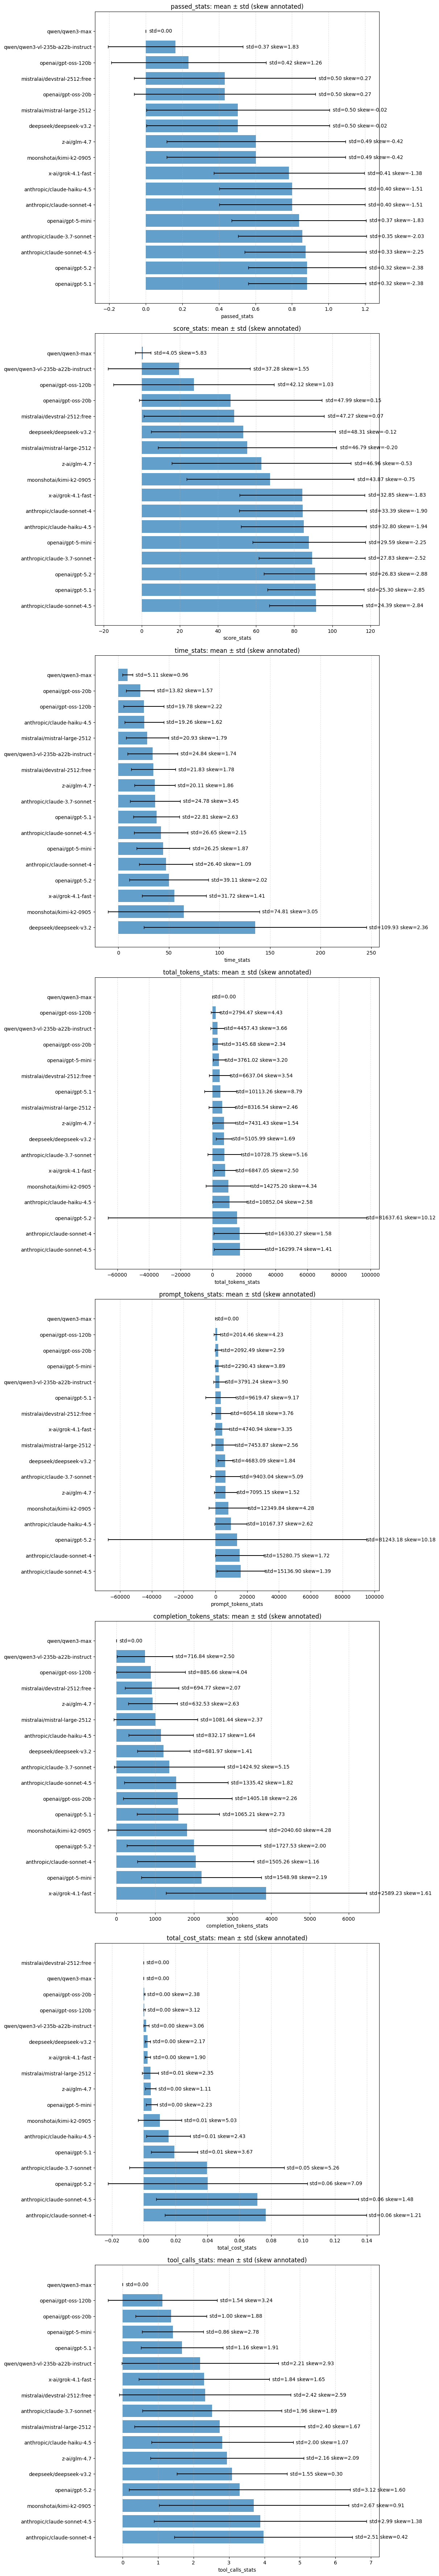

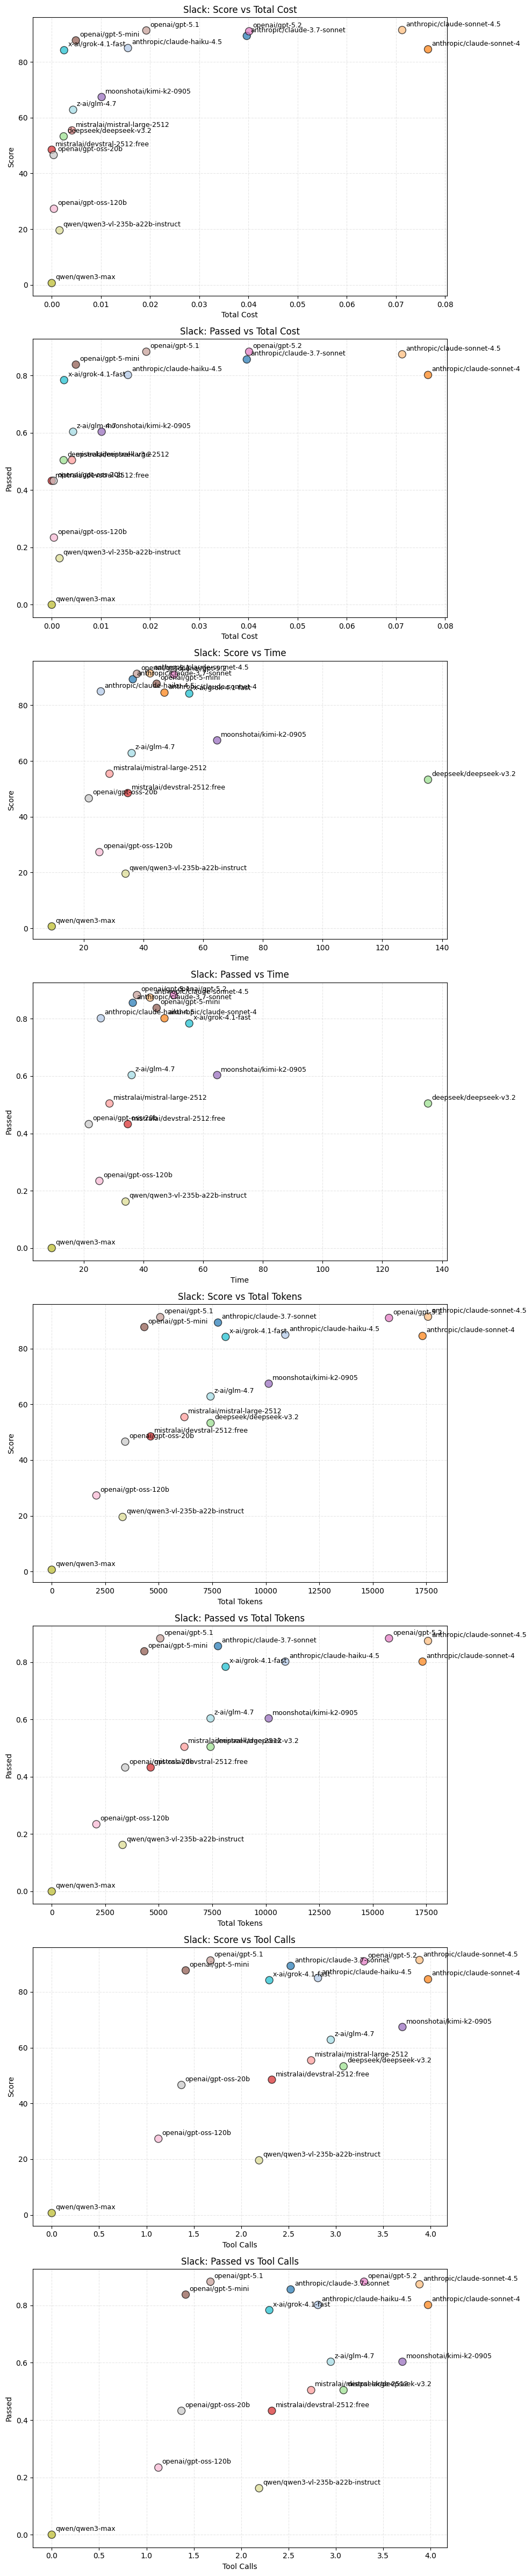

In [ ]:
slack_basic_stats = get_basic_stats(slack_data_raw)
plot_stats(slack_basic_stats)
plot_scatter_stats(slack_basic_stats, "Slack")

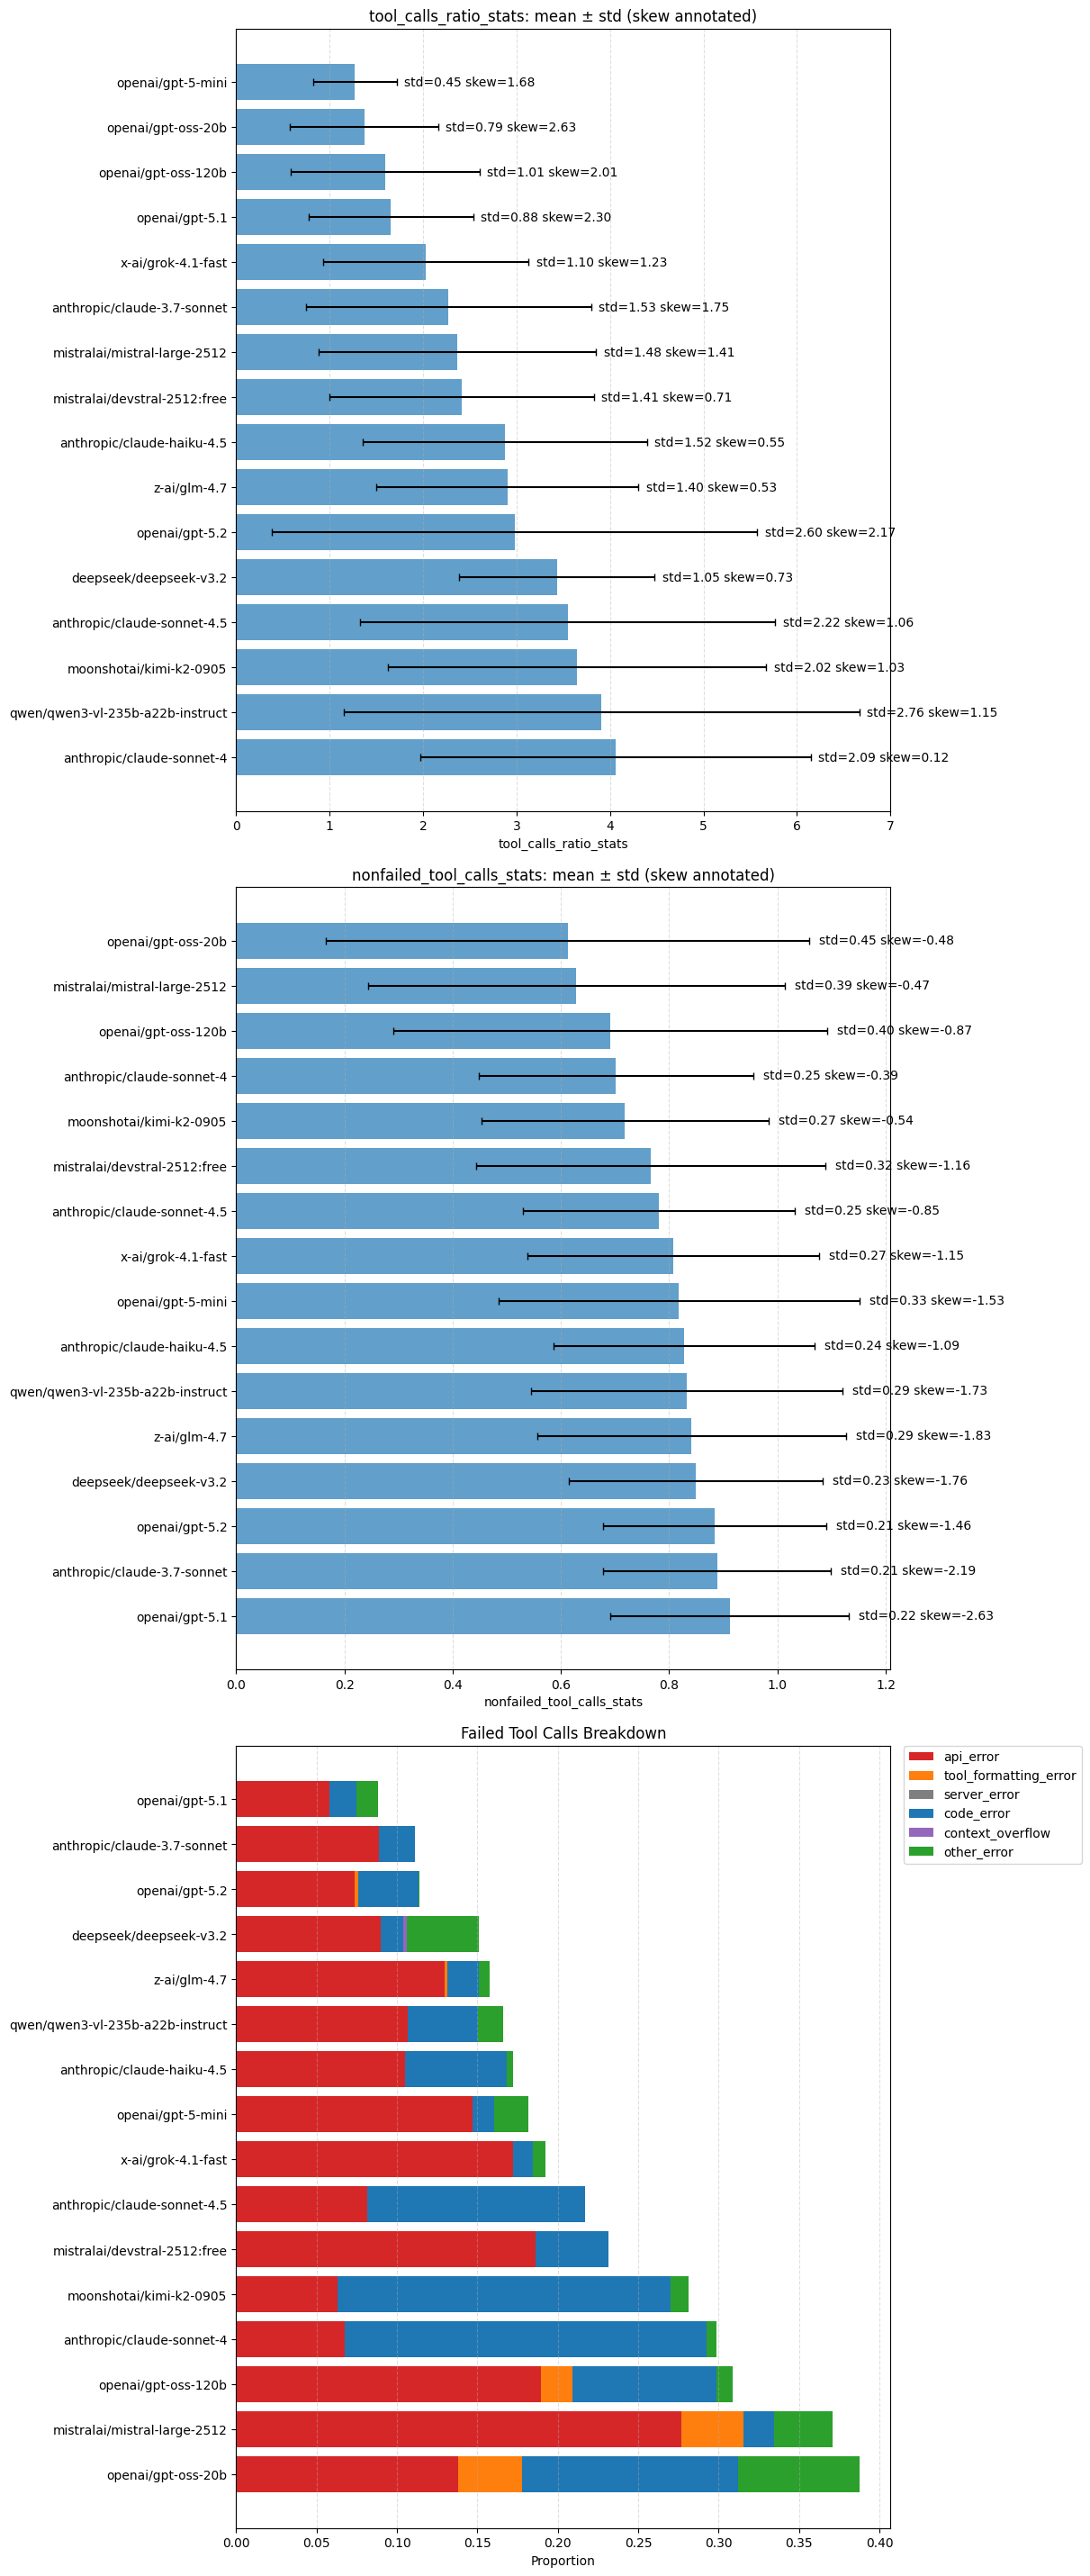

In [ ]:
slack_traces_stats = get_traces_stats(slack_traces_data)
plot_stats(slack_traces_stats)

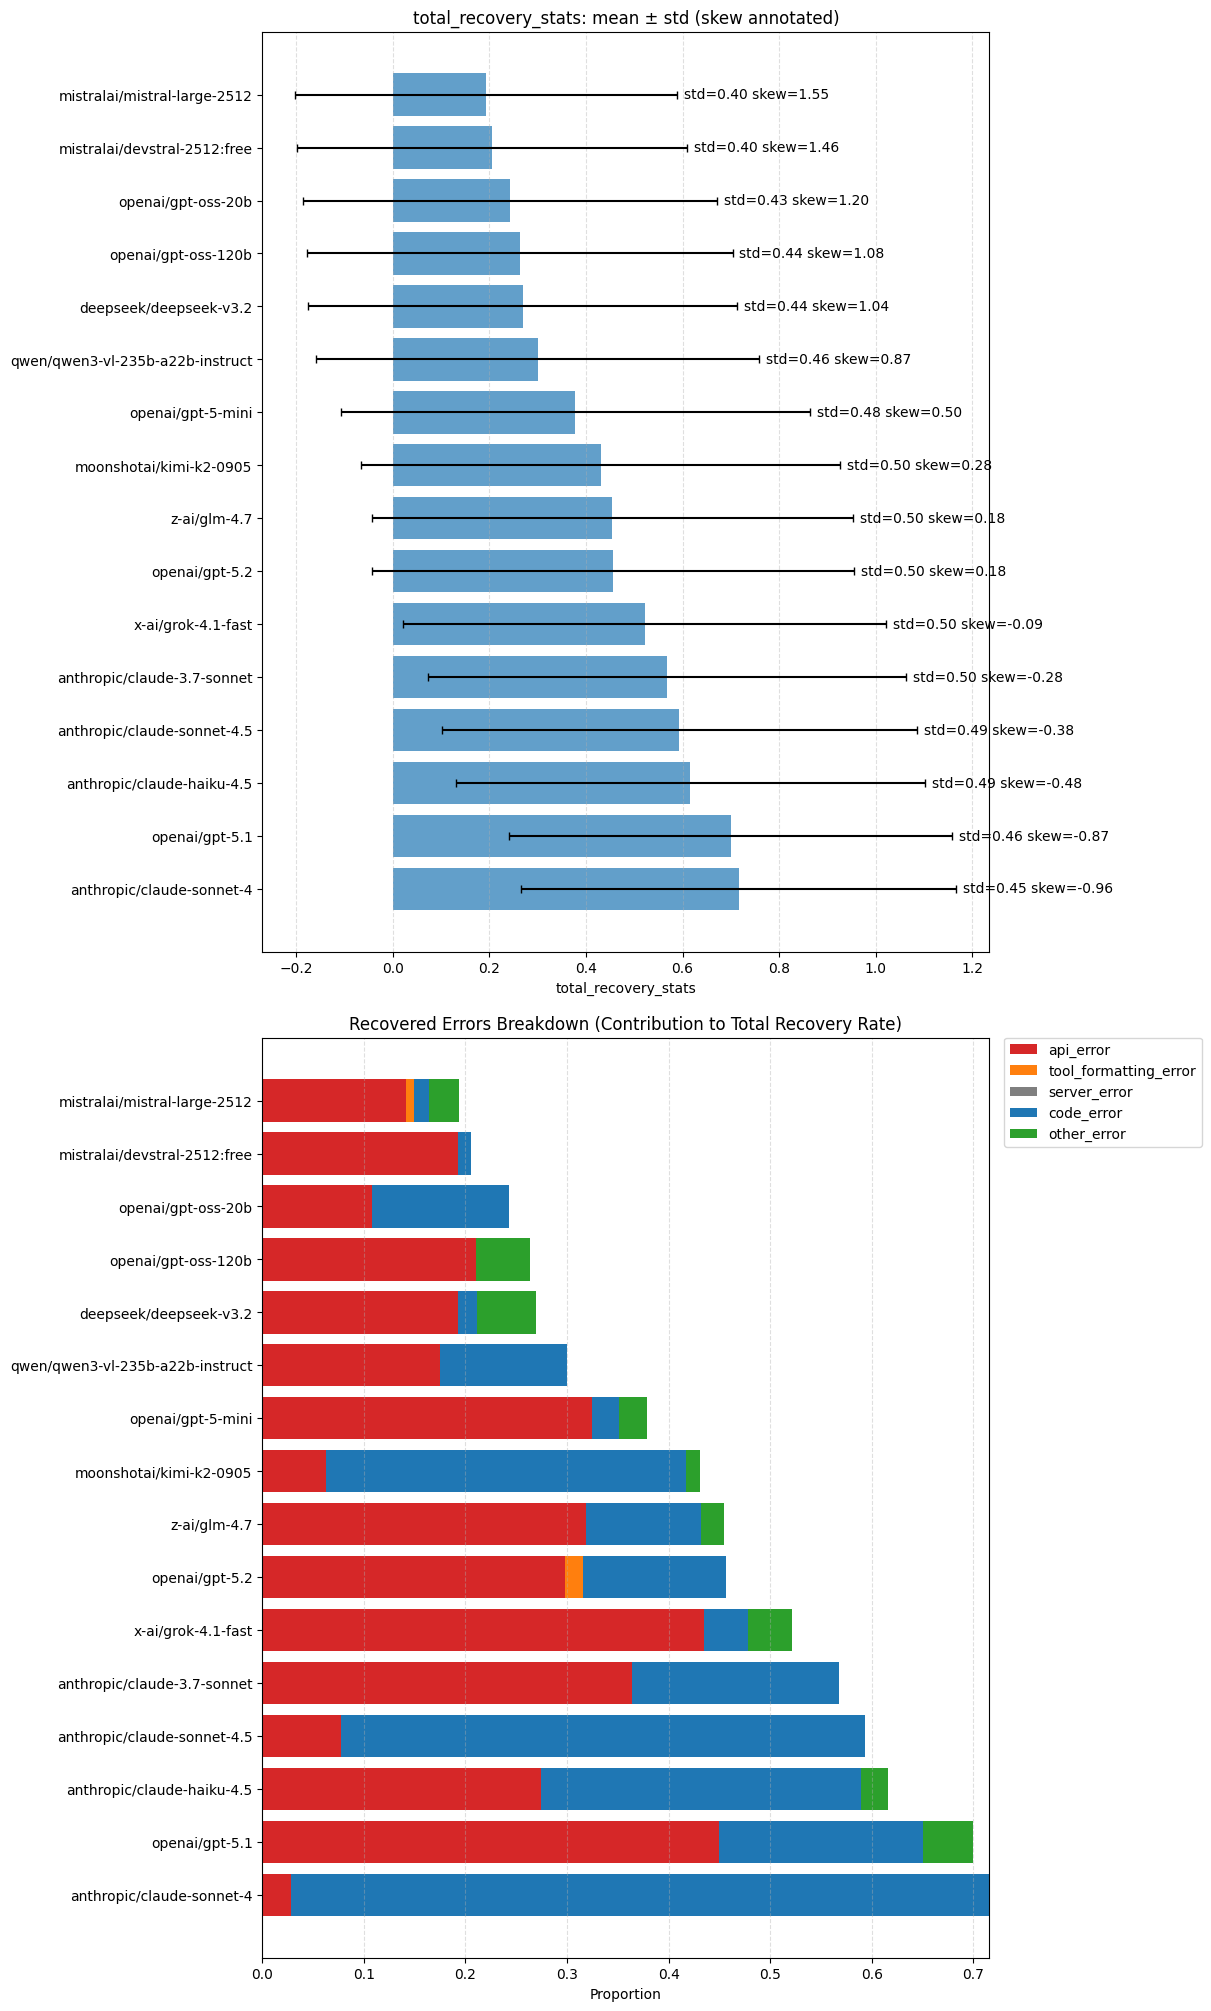

In [ ]:
slack_recovery_stats = get_recovery_stats(slack_traces_data)
plot_stats(slack_recovery_stats)

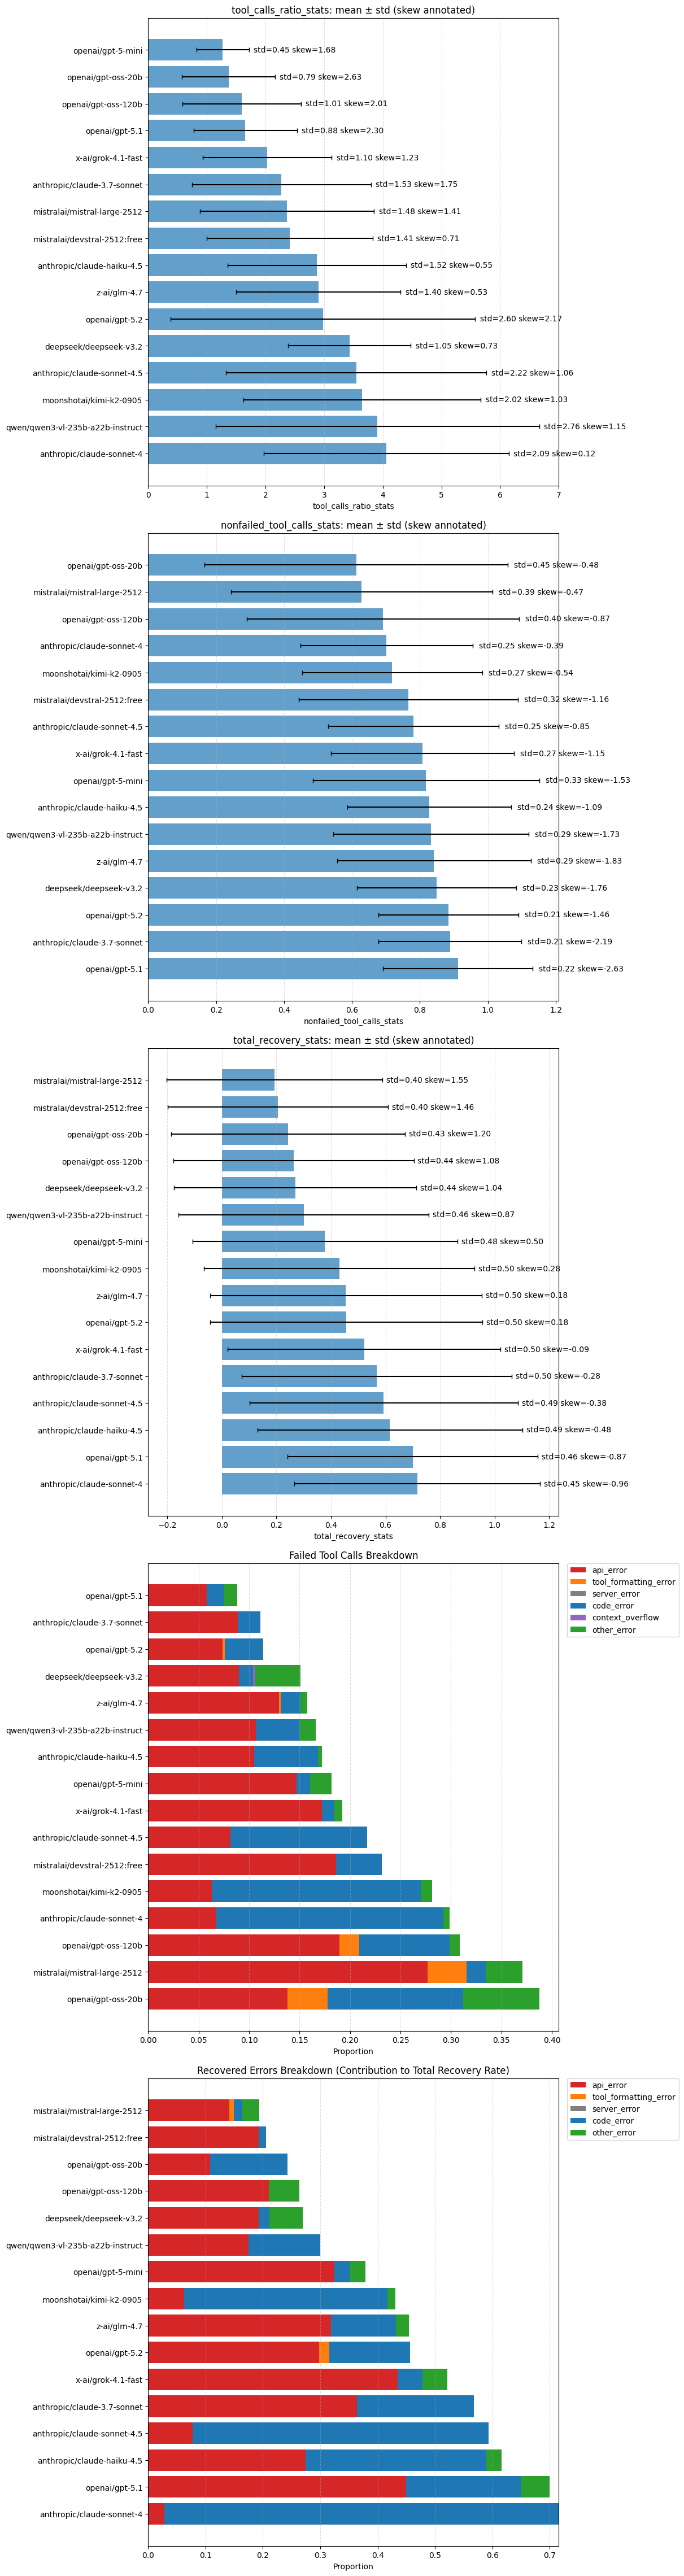

In [ ]:
all_slack_stats = {**slack_traces_stats, **slack_recovery_stats}
plot_stats(all_slack_stats)

In [ ]:
def inspect_other_errors(data, classifier_func, limit=20):
    count = 0
    print(f"--- Inspecting 'other_error' classifications (Showing first {limit}) ---")
    for test in data:
        model = test["model"]
        test_id = test["test_id"]
        for run in test["runs"]:
            if "messages" not in run["trace"]:
                continue

            # Build response map first to match tools to responses
            response_map = {}
            messages = run["trace"]["messages"]
            for message in messages:
                if "tool_call_id" in message:
                    response_map[message["tool_call_id"]] = message.get("content", "")

            # Check tool calls
            for message in messages:
                if "tool_calls" in message:
                    for tool_call in message["tool_calls"]:
                        tool_call_id = tool_call["id"]
                        if tool_call_id in response_map:
                            content = response_map[tool_call_id]
                            label = classifier_func(content)
                            if label == "other_error":
                                print(f"\n[Model: {model}] [Test: {test_id}] [Run: {run['run_id']}]")

                                # Safe access for tool name
                                if 'function' in tool_call:
                                    tool_name = tool_call['function'].get('name', 'Unknown Function')
                                else:
                                    tool_name = f"Unknown Tool Structure (keys: {list(tool_call.keys())})"

                                print(f"Tool Name: {tool_name}")
                                print(f"Error Content snippet:\n{content[:600]}..." if len(content) > 600 else f"Error Content:\n{content}")
                                print("-" * 40)
                                count += 1
                                if count >= limit:
                                    return
    if count == 0:
        print("No 'other_error' found.")

# Run the inspection on the raw Slack data
inspect_other_errors(slack_data_raw, classify_tool_response_slack, limit=15)

--- Inspecting 'other_error' classifications (Showing first 15) ---

[Model: anthropic/claude-haiku-4.5] [Test: test_29] [Run: cb8c2839-0ae3-488a-a4b6-622dd17c1f01]
Tool Name: Unknown Tool Structure (keys: ['name', 'args', 'id', 'type'])
Error Content:
Error: Error: 0

----------------------------------------

[Model: anthropic/claude-haiku-4.5] [Test: test_30] [Run: fd32d1ee-1517-4c3e-8c4d-d076bc86a7f2]
Tool Name: Unknown Tool Structure (keys: ['name', 'args', 'id', 'type'])
Error Content:
Error: Error: cannot import name 'set' from 'collections' (/opt/anaconda3/lib/python3.12/collections/__init__.py)

----------------------------------------

[Model: anthropic/claude-haiku-4.5] [Test: test_30] [Run: 0ce62cb9-578f-46c0-92f5-91674d98df84]
Tool Name: Unknown Tool Structure (keys: ['name', 'args', 'id', 'type'])
Error Content:
Error: Error: cannot import name 'set' from 'collections' (/opt/anaconda3/lib/python3.12/collections/__init__.py)

----------------------------------------

[Model

In [ ]:
def collect_and_save_error_samples(data, classifier_func, output_path):
    # Structure: samples[model][error_type] = [ { test_id, run_id, tool_name, content }, ... ]
    samples = defaultdict(lambda: defaultdict(list))
    limit_per_type = 10

    print(f"--- Collecting up to {limit_per_type} samples per error type per model ---")

    for test in data:
        model = test["model"]
        test_id = test["test_id"]
        for run in test["runs"]:
            if "messages" not in run["trace"]:
                continue

            # Build response map
            response_map = {}
            messages = run["trace"]["messages"]
            for message in messages:
                if "tool_call_id" in message:
                    response_map[message["tool_call_id"]] = message.get("content", "")

            # Check tool calls
            for message in messages:
                if "tool_calls" in message:
                    for tool_call in message["tool_calls"]:
                        tool_call_id = tool_call["id"]
                        if tool_call_id in response_map:
                            content = response_map[tool_call_id]
                            label = classifier_func(content)

                            # We only care about errors, not successes or 'no_response'
                            if label != "non-failure" and label != "no_response":

                                # Check if we already have enough samples for this model+error_type
                                if len(samples[model][label]) < limit_per_type:

                                    # Safe tool name extraction
                                    if 'function' in tool_call:
                                        tool_name = tool_call['function'].get('name', 'Unknown Function')
                                    else:
                                        tool_name = f"Unknown Structure keys: {list(tool_call.keys())}"

                                    entry = {
                                        "test_id": test_id,
                                        "run_id": run["run_id"],
                                        "tool_name": tool_name,
                                        "error_type": label,
                                        "content": content
                                    }
                                    samples[model][label].append(entry)

    # Save to file
    out_path = Path(output_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert defaultdict to regular dict for JSON serialization
    final_output = {k: dict(v) for k, v in samples.items()}

    with out_path.open("w", encoding="utf-8") as f:
        json.dump(final_output, f, indent=2)

    print(f"Samples saved to: {out_path}")

    # Print a preview (1 of each type found for each model)
    print("\n--- Preview of Collected Errors ---")
    for model, error_types in samples.items():
        print(f"\nModel: {model}")
        for err_type, examples in error_types.items():
            ex = examples[0]
            print(f"  [{err_type}] Tool: {ex['tool_name']}")
            preview = ex['content'][:200].replace('\n', ' ') + "..." if len(ex['content']) > 100 else ex['content'].replace('\n', ' ')
            print(f"    -> {preview}")

# Run the collection
output_file = "/content/drive/MyDrive/API research/evaluation runs/Slack/normalized/slack_error_samples.json"
collect_and_save_error_samples(slack_data_raw, classify_tool_response_slack, output_file)

--- Collecting up to 10 samples per error type per model ---
Samples saved to: /content/drive/MyDrive/API research/evaluation runs/Slack/normalized/slack_error_samples.json

--- Preview of Collected Errors ---

Model: anthropic/claude-haiku-4.5
  [code_error] Tool: Unknown Structure keys: ['name', 'args', 'id', 'type']
    -> Error: Error: name 'headers' is not defined 
  [api_error] Tool: Unknown Structure keys: ['name', 'args', 'id', 'type']
    -> Conversation open response: {   "ok": false,   "error": "users_list_not_supplied" }  ✗ Failed to open group conversation: users_list_not_supplied ...
  [other_error] Tool: Unknown Structure keys: ['name', 'args', 'id', 'type']
    -> Error: Error: 0 

Model: openai/gpt-5-mini
  [code_error] Tool: Unknown Structure keys: ['name', 'args', 'id', 'type']
    -> Error: Traceback (most recent call last):   File "<stdin>", line 2, in <module>   File "/opt/anaconda3/lib/python3.12/json/__init__.py", line 293, in load     return loads(fp.read(),   

# Analyze Linear

In [ ]:
linear_path = Path("/content/drive/MyDrive/API research/evaluation runs/Linear/normalized/linear_full_results_normalized.json")
with linear_path.open() as f:
    linear_data_raw = json.load(f)

linear_out_path = "/content/drive/MyDrive/API research/evaluation runs/Linear/normalized/linear_classified.json"
linear_traces_data = classify_traces(linear_data_raw, classify_tool_response_linear, linear_out_path)

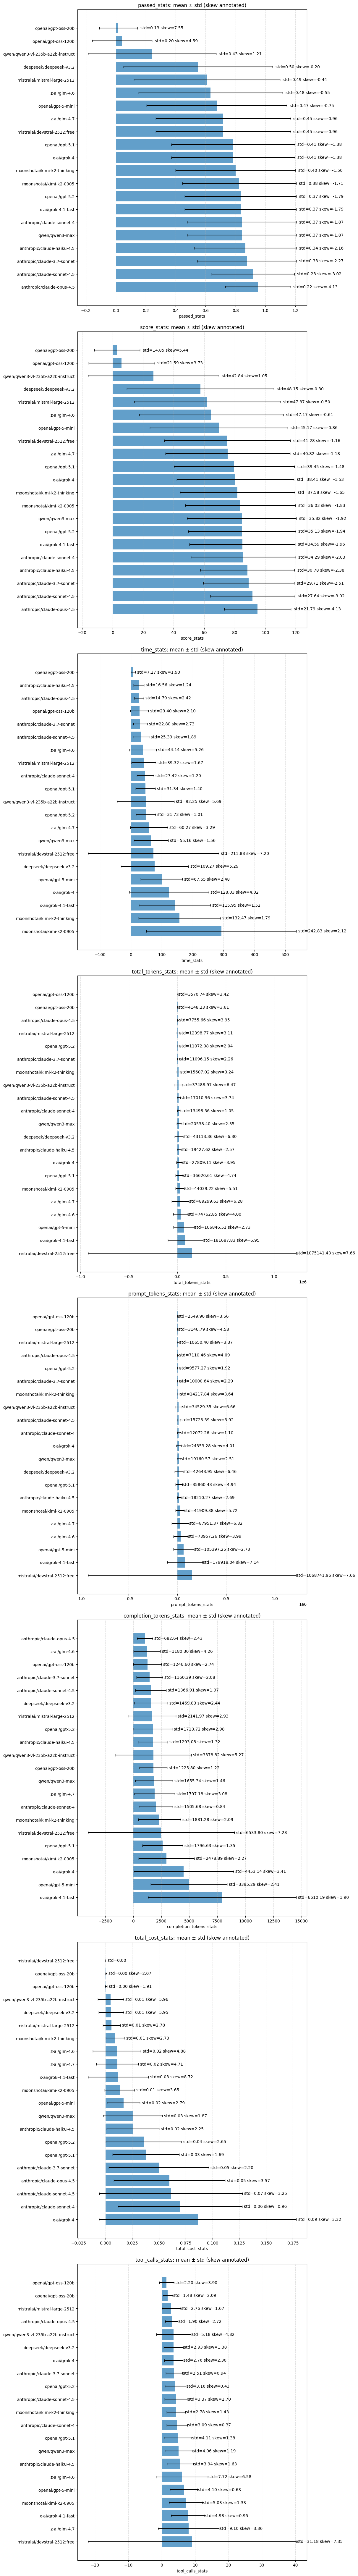

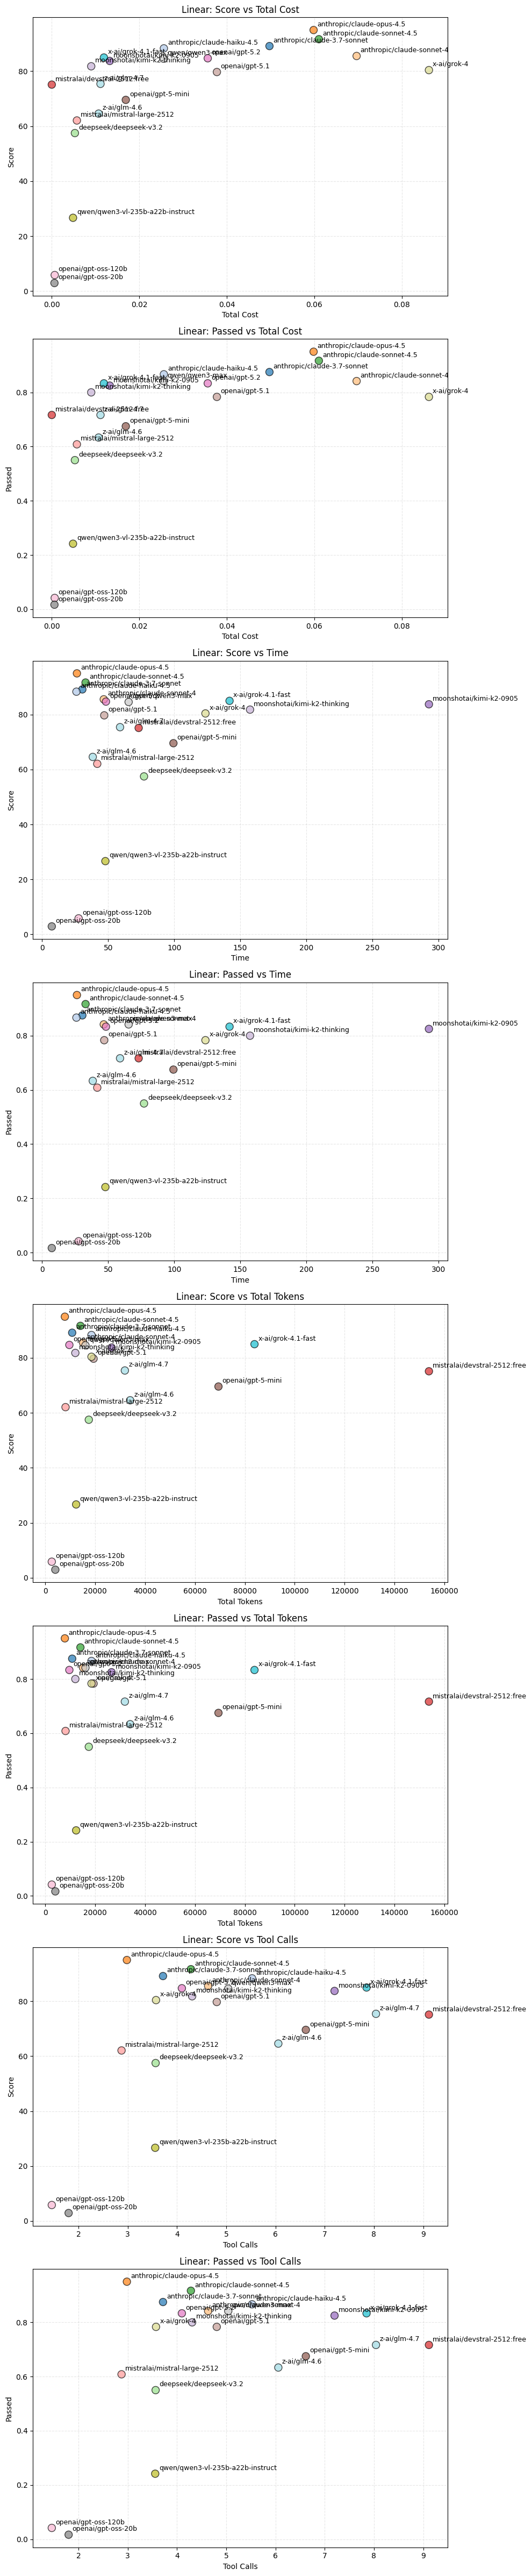

In [ ]:
linear_basic_stats = get_basic_stats(linear_data_raw)
plot_stats(linear_basic_stats)
plot_scatter_stats(linear_basic_stats, "Linear")

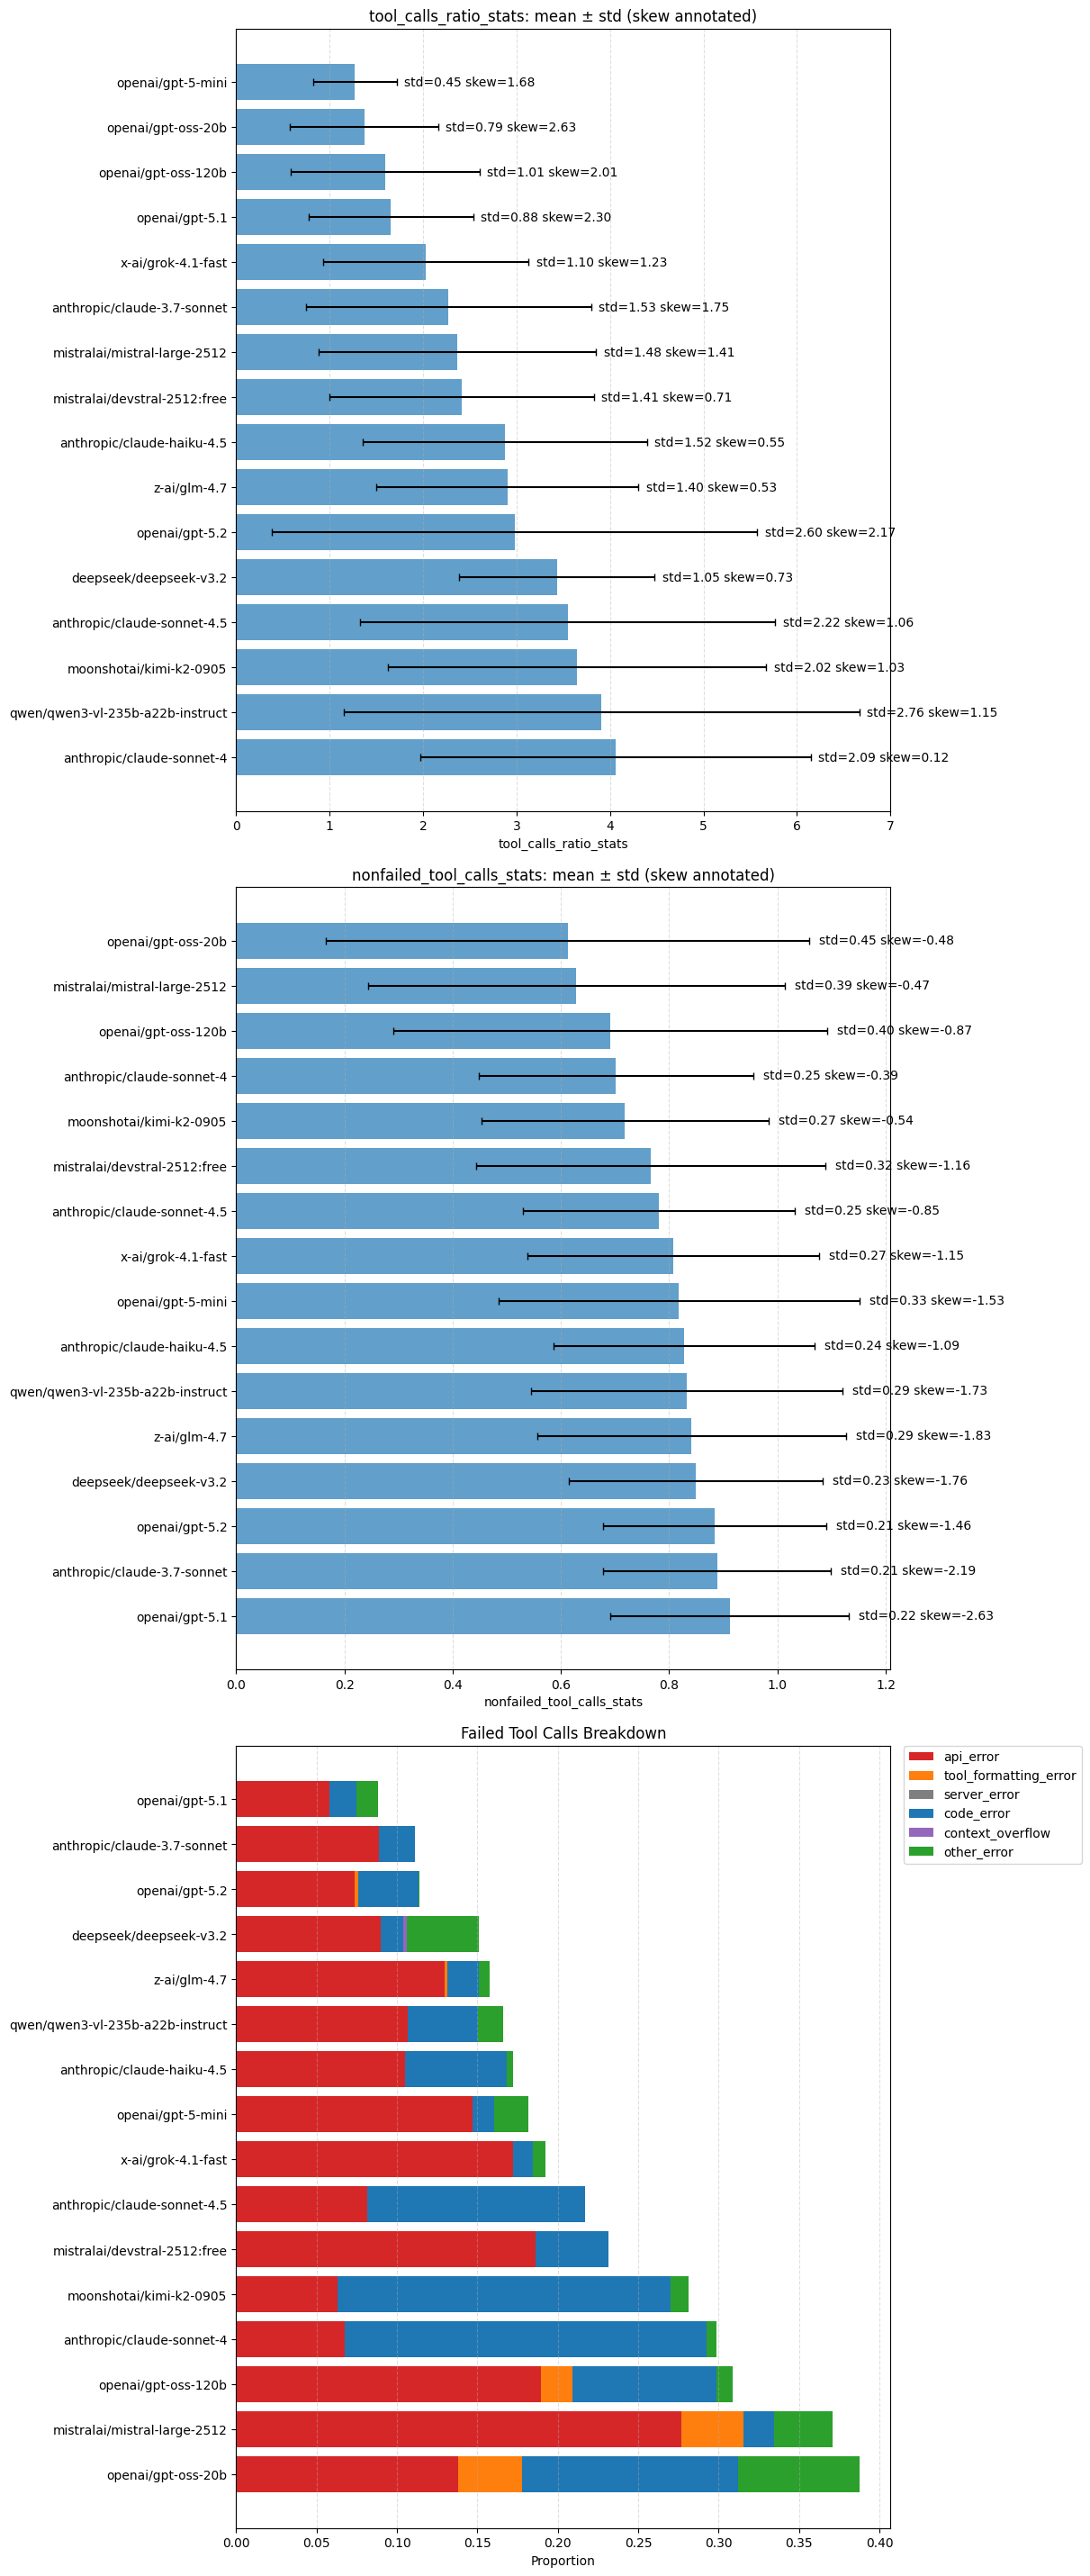

In [ ]:
linear_traces_stats = get_traces_stats(linear_traces_data)
plot_stats(slack_traces_stats)

/tmp/ipython-input-4090927975.py:465: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skew": float(skew(row)) if len(row) >= 3 else None,


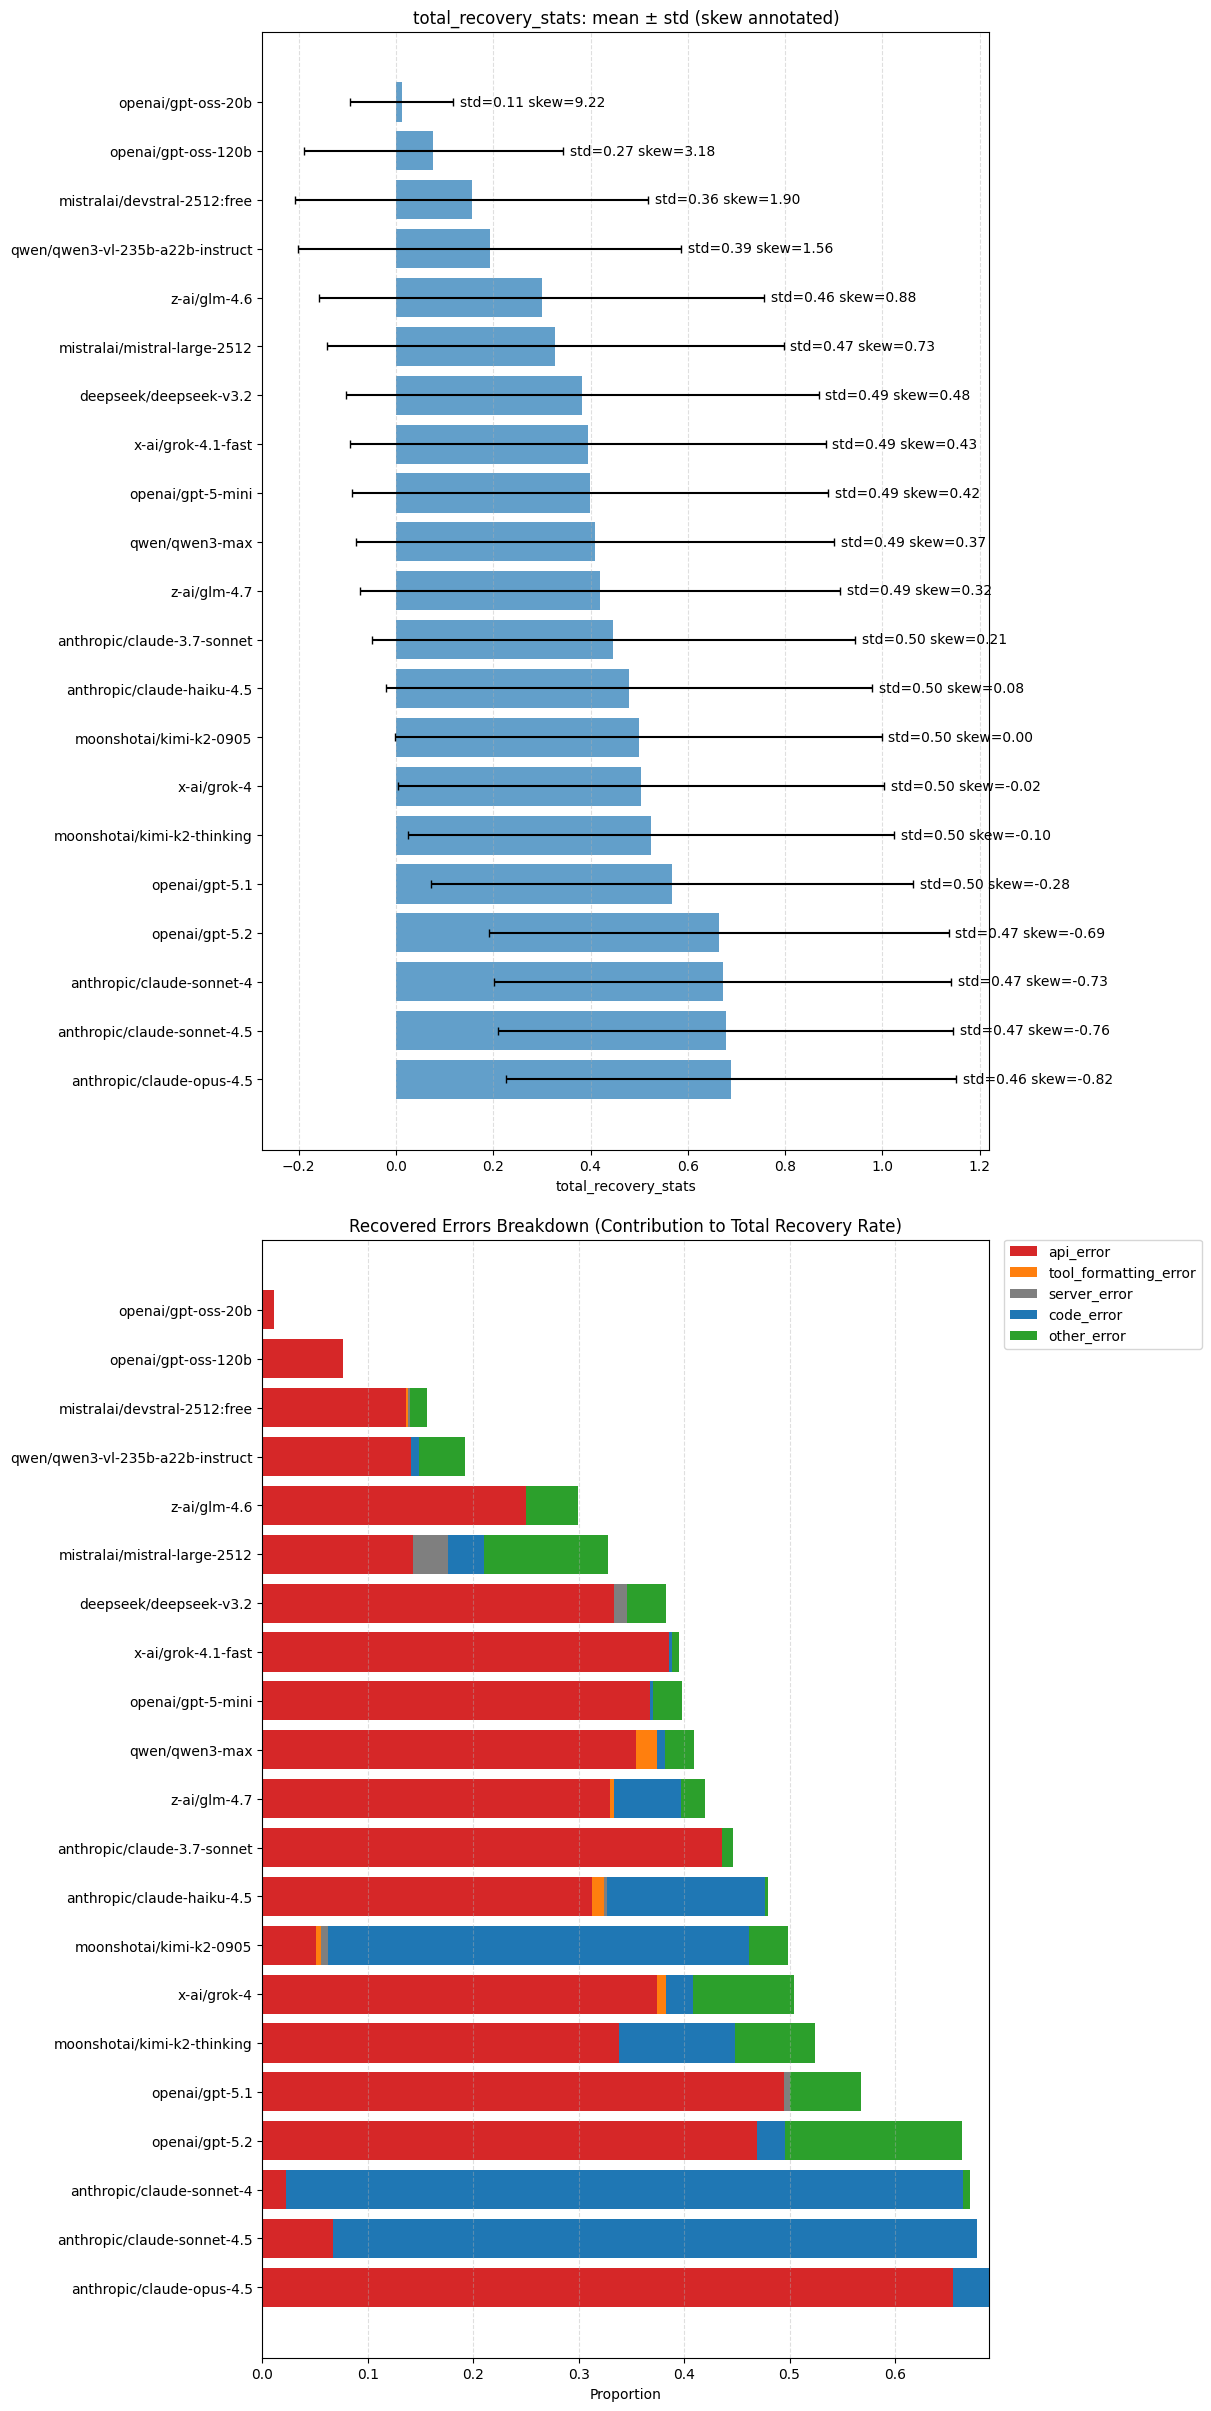

In [ ]:
linear_recovery_stats = get_recovery_stats(linear_traces_data)
plot_stats(linear_recovery_stats)

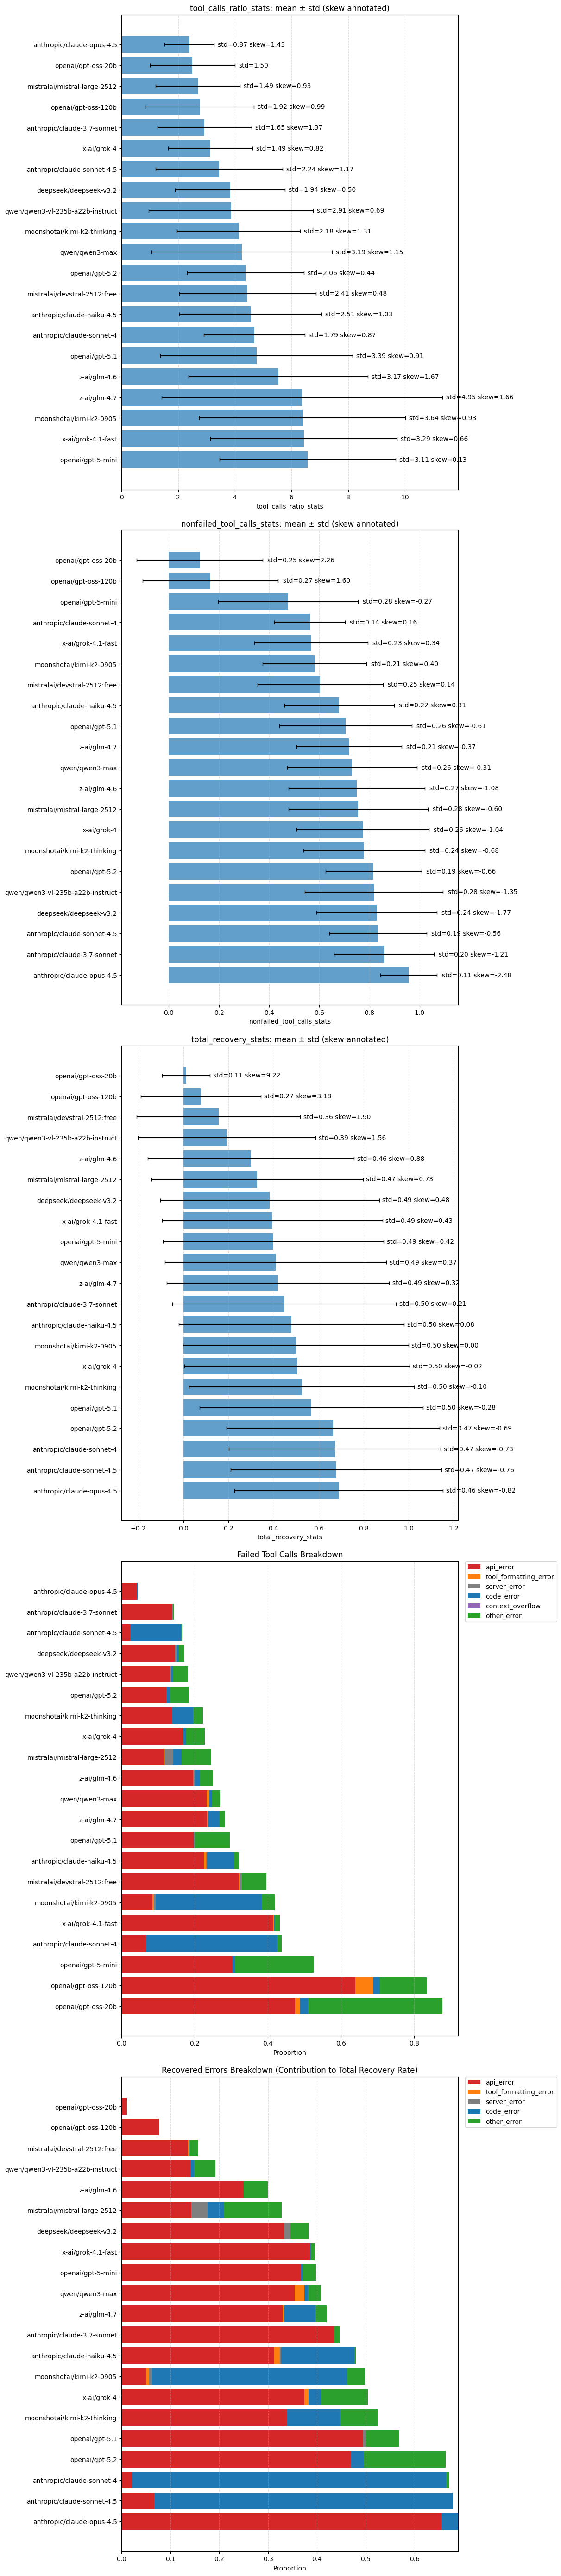

In [ ]:
all_linear_stats = {**linear_traces_stats, **linear_recovery_stats}
plot_stats(all_linear_stats)

Comparing 17 common models: anthropic/claude-3.7-sonnet, anthropic/claude-haiku-4.5, anthropic/claude-sonnet-4, anthropic/claude-sonnet-4.5, deepseek/deepseek-v3.2, mistralai/devstral-2512:free, mistralai/mistral-large-2512, moonshotai/kimi-k2-0905, openai/gpt-5-mini, openai/gpt-5.1, openai/gpt-5.2, openai/gpt-oss-120b, openai/gpt-oss-20b, qwen/qwen3-max, qwen/qwen3-vl-235b-a22b-instruct, x-ai/grok-4.1-fast, z-ai/glm-4.7


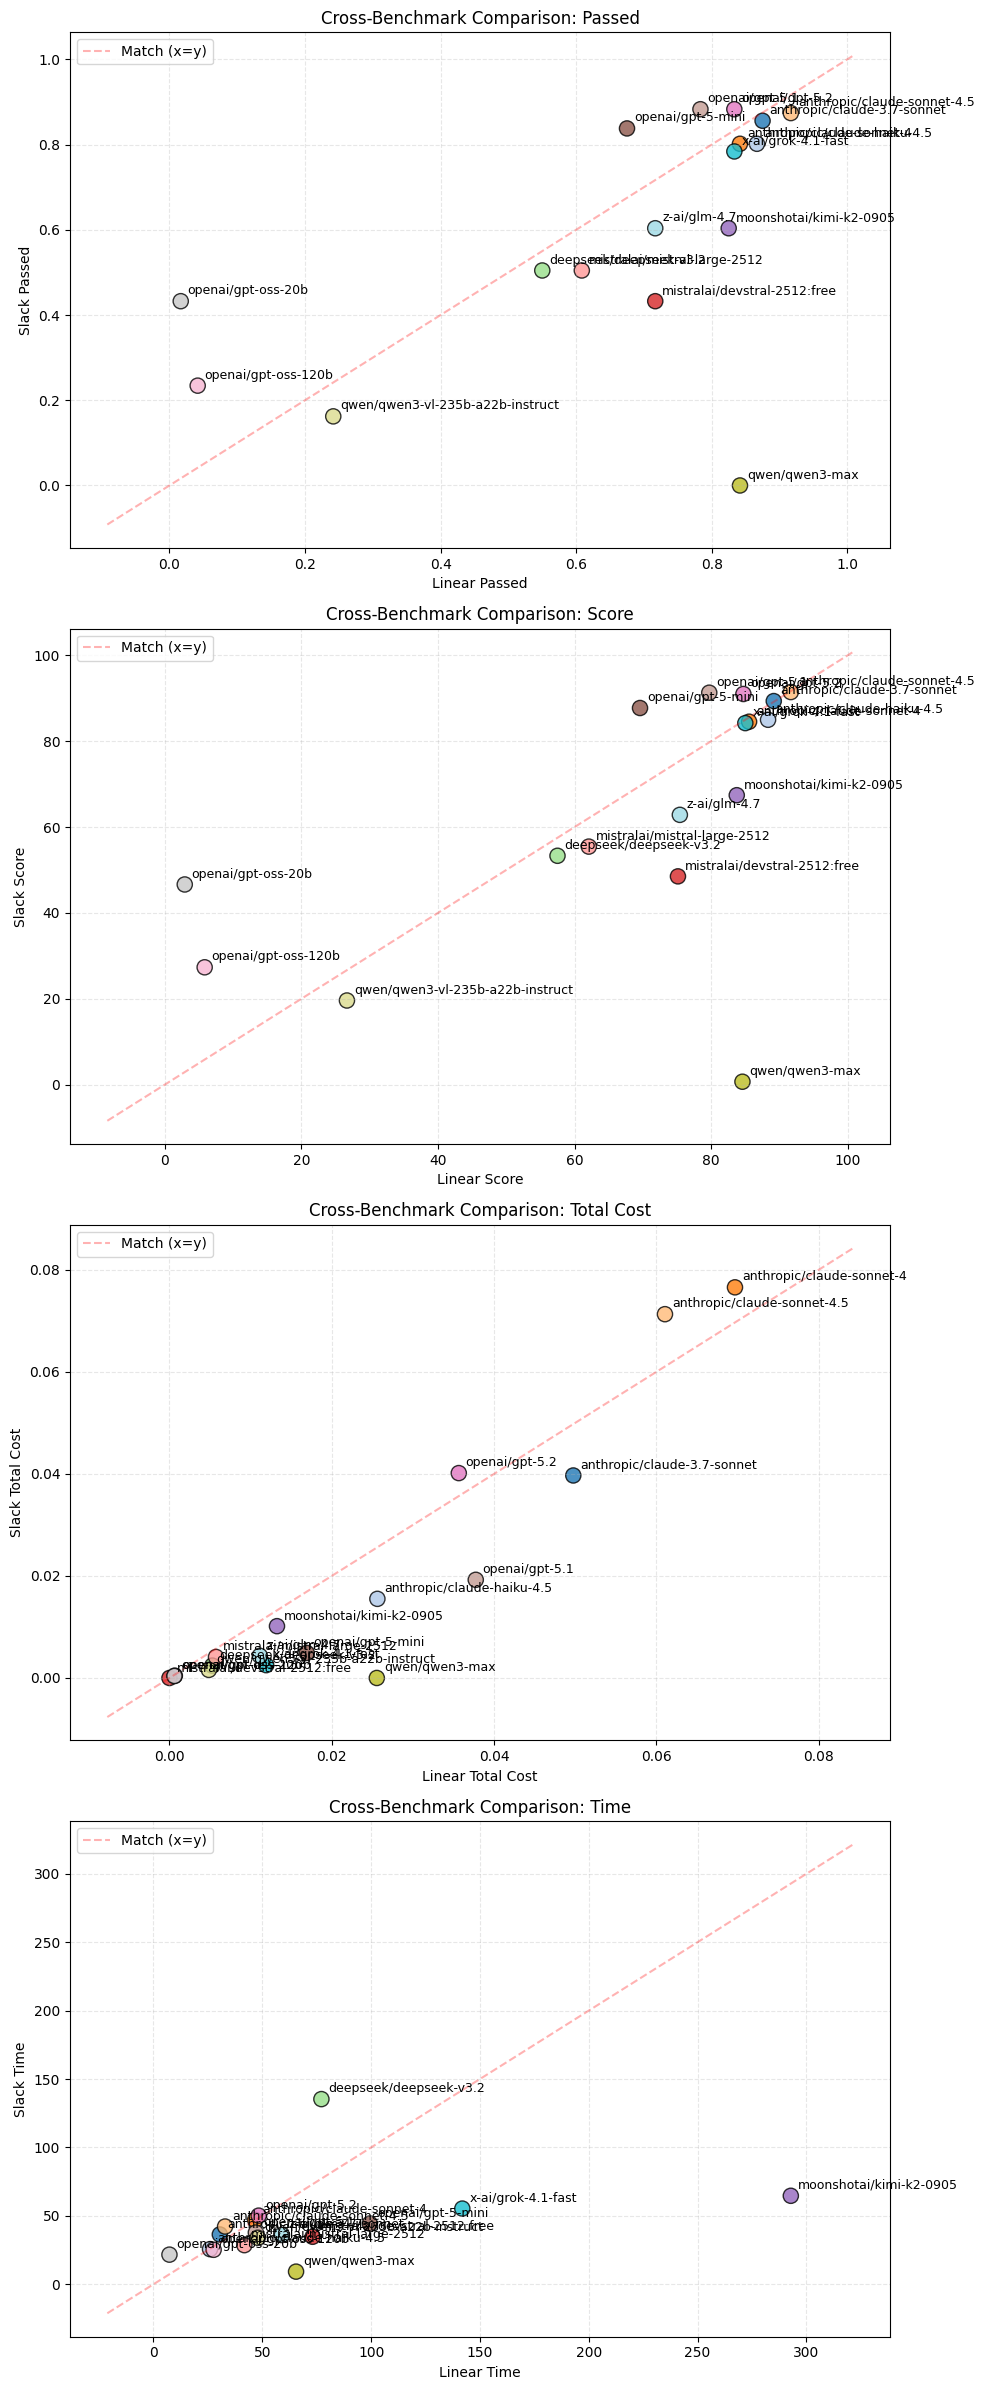

In [ ]:
plot_cross_benchmark_stats(slack_basic_stats, linear_basic_stats)

Comparing 17 common models across 9 metrics.


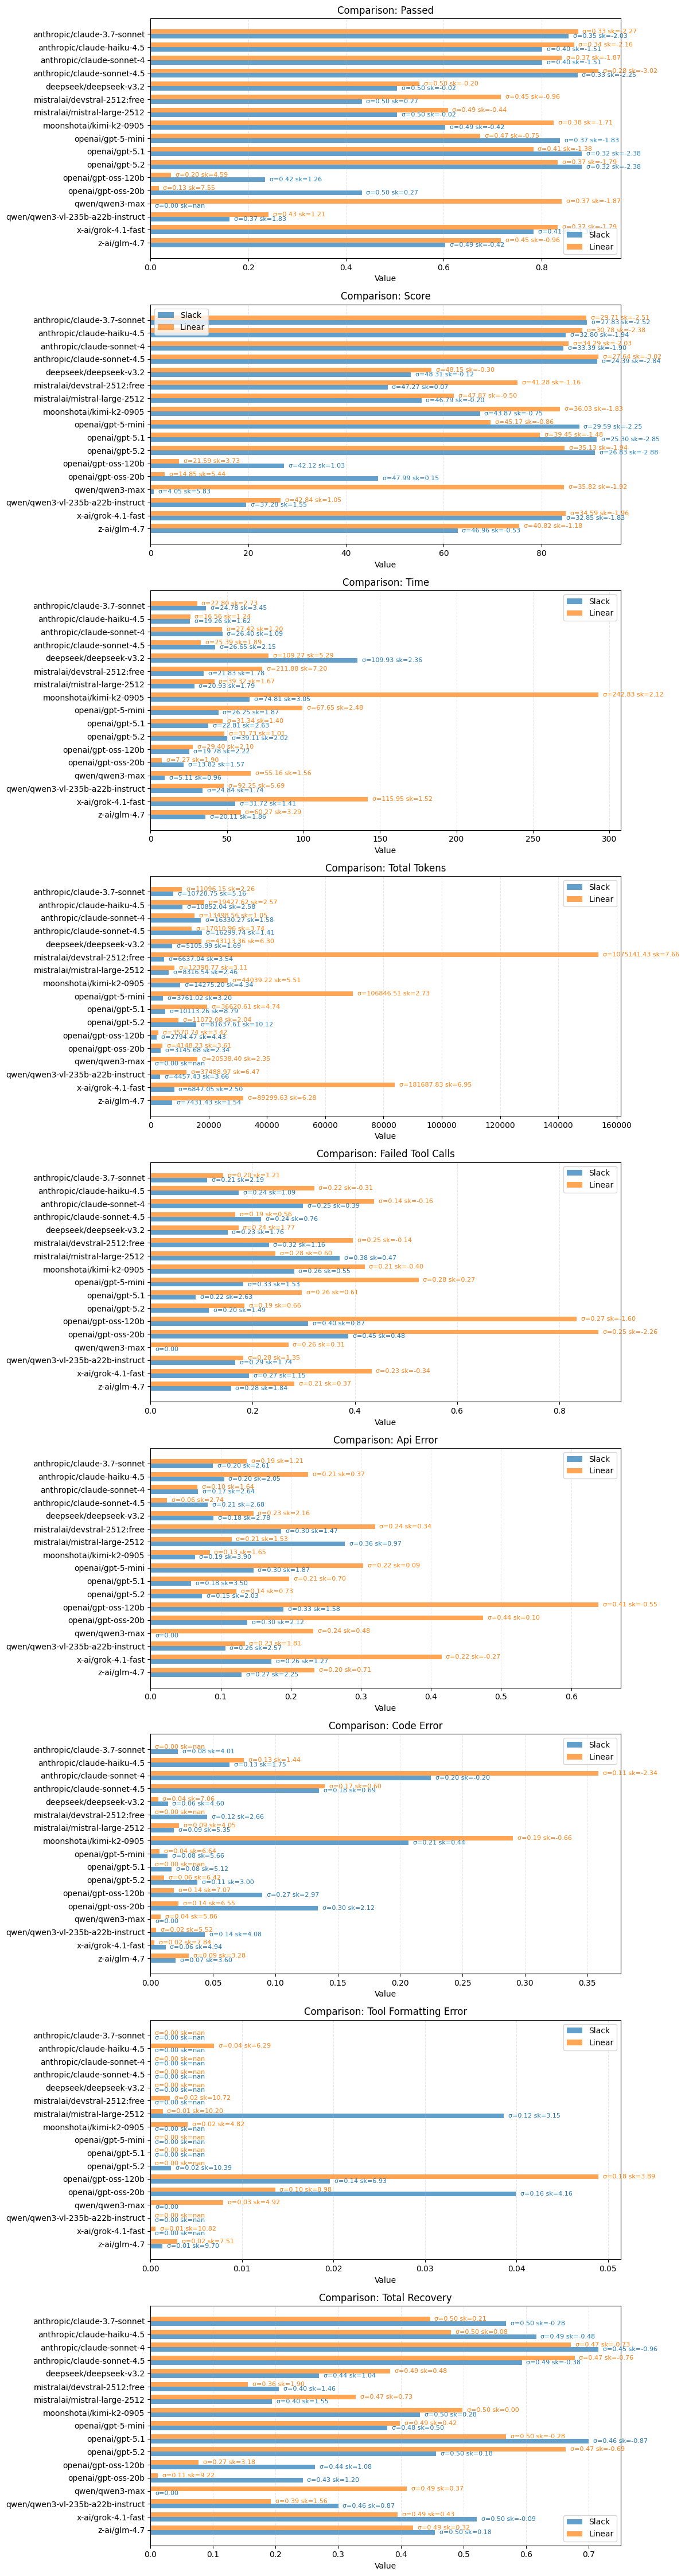

In [ ]:
# Prepare combined stats dictionaries
# Merging basic stats + trace stats (errors) + recovery stats
full_slack_stats = {**slack_basic_stats, **slack_traces_stats, **slack_recovery_stats}
full_linear_stats = {**linear_basic_stats, **linear_traces_stats, **linear_recovery_stats}

# Define metrics we want to compare
metrics_of_interest = [
    'passed_stats',           # Success Rate
    'score_stats',            # Quality Score
    'time_stats',             # Execution Time
    'total_tokens_stats',     # Token Usage
    'failed_tool_calls_stats',# Overall Error Rate
    'api_error_stats',        # Specific Error: API
    'code_error_stats',       # Specific Error: Code
    'tool_formatting_error_stats', # Specific Error: Formatting
    'total_recovery_stats'
]

# Re-run plotting with annotations
plot_grouped_cross_benchmark_bars(full_slack_stats, full_linear_stats, metrics_of_interest)

In [ ]:
def plot_cost_vs_score_combined(slack_stats, linear_stats):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Helper to extract data
    def extract_data(stats, cost_key='total_cost_stats', score_key='score_stats'):
        costs = []
        scores = []
        labels = []
        for model, metric_stats in stats[cost_key].items():
            cost_val = metric_stats['mean']
            score_val = stats[score_key][model]['mean']

            if cost_val is not None and score_val is not None:
                costs.append(cost_val)
                scores.append(score_val)
                labels.append(model)
        return costs, scores, labels

    # Slack Data
    s_costs, s_scores, s_labels = extract_data(slack_stats)
    # Linear Data
    l_costs, l_scores, l_labels = extract_data(linear_stats)

    # Plot
    ax.scatter(s_costs, s_scores, c='tab:blue', label='Slack', s=100, alpha=0.7, edgecolors='k', marker='o')
    ax.scatter(l_costs, l_scores, c='tab:orange', label='Linear', s=100, alpha=0.7, edgecolors='k', marker='^')

    # Annotate Slack
    for i, label in enumerate(s_labels):
        ax.annotate(label, (s_costs[i], s_scores[i]), xytext=(5, 5), textcoords='offset points', fontsize=8, color='tab:blue', alpha=0.8)

    # Annotate Linear
    for i, label in enumerate(l_labels):
        ax.annotate(label, (l_costs[i], l_scores[i]), xytext=(5, -10), textcoords='offset points', fontsize=8, color='tab:orange', alpha=0.8)

    ax.set_xlabel("Mean Total Cost ($)")
    ax.set_ylabel("Mean Score")
    ax.set_title("Cost vs. Score: Slack vs Linear")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the function with the stats computed in previous cells
plot_cost_vs_score_combined(slack_basic_stats, linear_basic_stats)

NameError: name 'slack_basic_stats' is not defined